# Data import

In [1]:
import utils as ut
import plots as pt
from ccc_garch import mgarch_single
from ms_ccc_garch_2 import mgarch
from ms_ccc_garch_3 import mgarch_3_regimes
from dcc import dcc
import numpy as np
import pandas as pd

from scipy.special import hankel1, hankel2,gamma,kv,kn
from scipy.linalg import norm,expm
import numpy as np
from scipy.optimize import minimize
import scipy
import scipy.linalg.lapack as lapack
from numpy import exp,diag,zeros,array,std,log,sqrt,prod


df_all_close_fin_na = pd.read_pickle('data/prices_close')
df_comms_ret = pd.read_pickle('data/commodity_log_returns')

st_date = '2022-01-01'

ret_arr_gpe = df_comms_ret[st_date:].values
ret_arr_gpe.shape

0.2.2


(560, 3)

# Figure 1 Price Dynamics and EMWA conditional correlations 

In [2]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from itertools import combinations
import seaborn as sns
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('mode.chained_assignment', None)

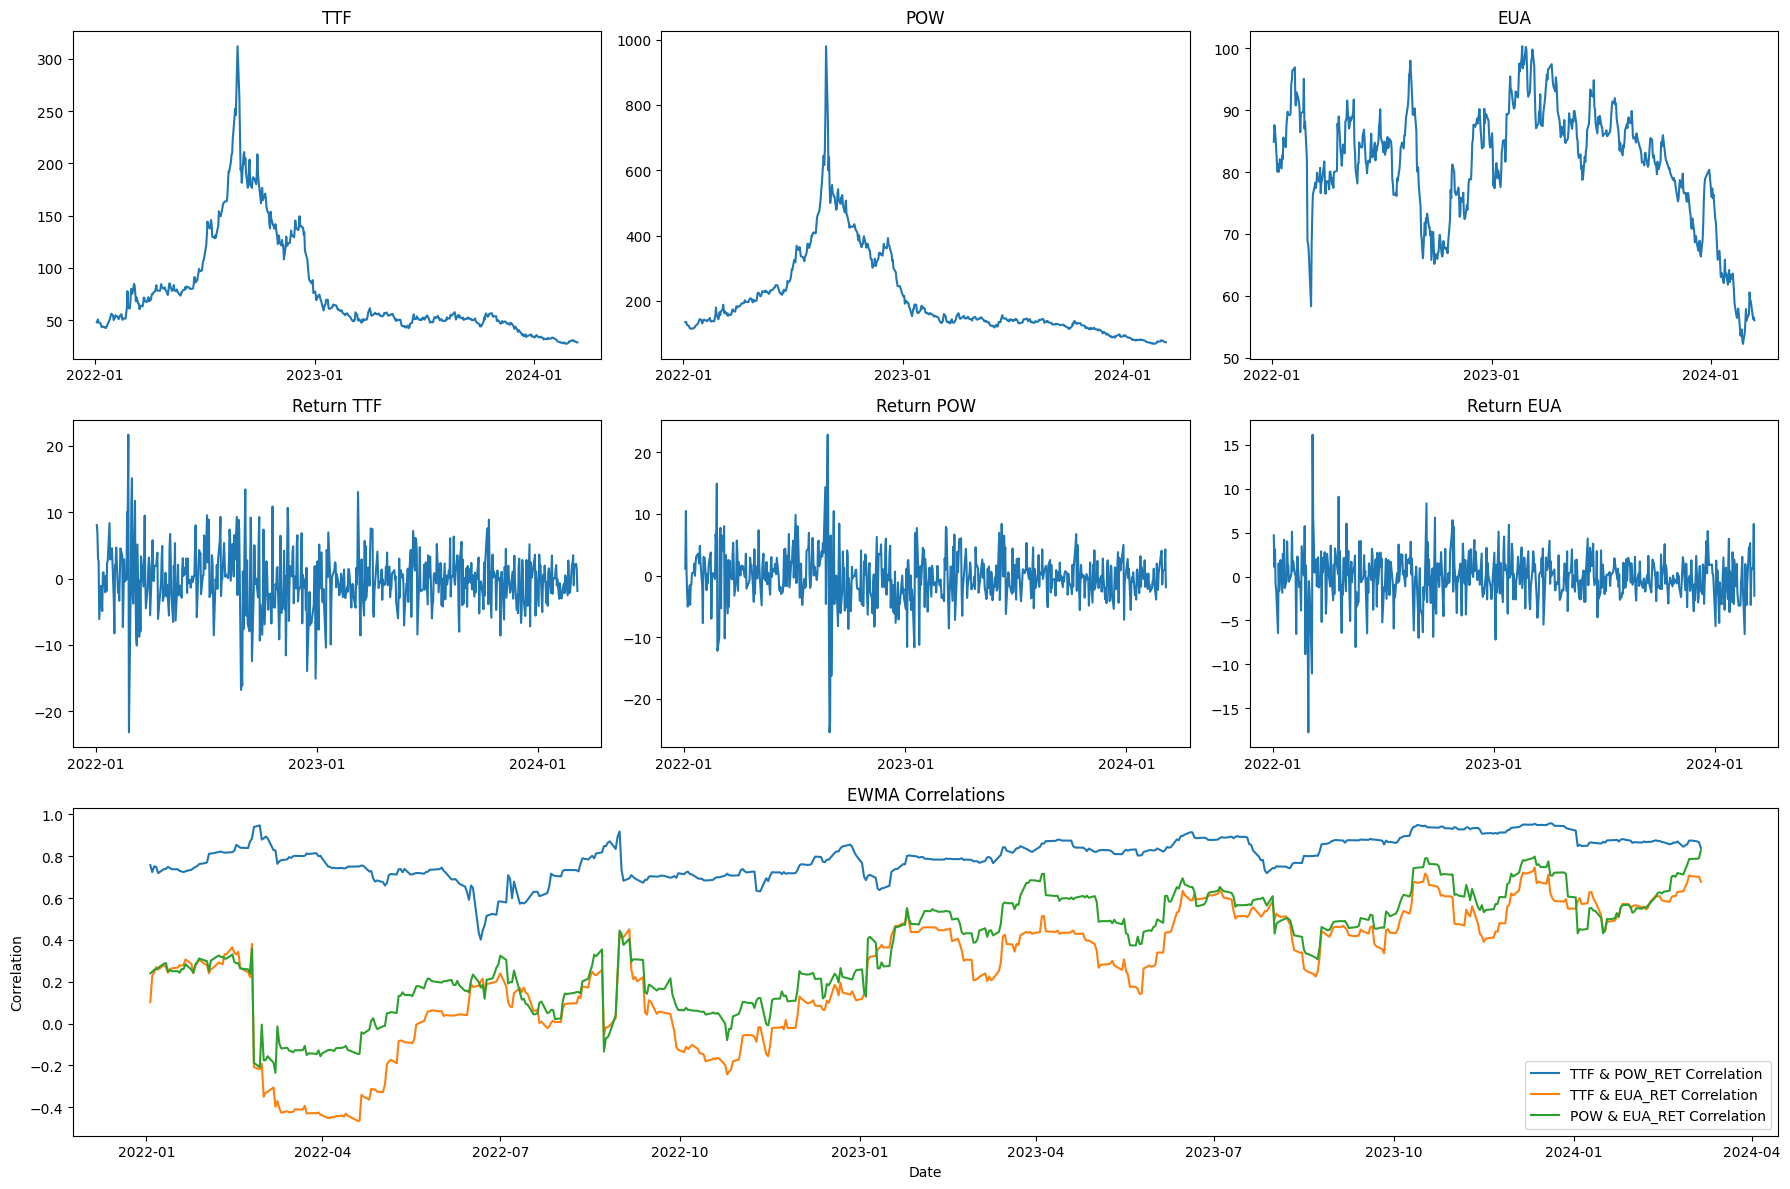

In [3]:
fig = pt.figure_1(df_all_close_fin_na[st_date:],df_comms_ret[st_date:])
plt.show(fig)

# Table 2 Summary statistics

In [4]:
import numpy as np
import pandas as pd
import scipy.stats as stats

df_stats = ut.calculate_statistics(ret_arr_gpe).round(2)
df_stats

,Max,Mean,Median,Min,Std,Skew,Kurtosis,Jarque-Bera,Jarque-Bera p-value
ttf,21.69,-0.05,0.07,-23.19,4.53,-0.17,2.81,186.51,0.0
pow,22.83,-0.08,-0.20,-25.42,4.12,-0.33,6.55,1009.85,0.0
eua,16.14,-0.07,0.06,-17.73,2.72,-0.33,5.58,737.66,0.0


# MLE estimation Table 3 

This section runs estimation of all model described in paper. Log-likelihood AIC and BIC are printed out, Table 3 is then created manually

## SIngle regime

### Norm

In [98]:
# if fails needs to be restarted
mgarch_single_norm = mgarch_single(ret = ret_arr_gpe, dist='norm')
res_single_norm = mgarch_single_norm.fit()

In [99]:
params_single_norm = mgarch_single_norm.get_params(res_single_norm.x)

In [100]:
std_err_norm_single = ut.std_errors(mgarch_single_norm.norm_err, params_single_norm)

In [101]:
df_estimates = pd.DataFrame({'param':params_single_norm.round(3),'std_err':std_err_norm_single.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
param,-0.15,-0.20,-0.18,0.3,0.20,0.00,0.16,0.20,0.11,0.80,0.79,0.92,-0.19,-0.17,0.04,0.80,0.24,0.35
std_err,0.14,0.12,0.09,0.1,0.06,0.02,0.02,0.02,0.02,0.04,0.03,0.02,0.09,0.07,0.12,0.02,0.04,0.04


In [102]:
ut.return_lrt(mgarch_single_norm.loglik,res_single_norm.x,ret_arr_gpe)

Loglik: -4046.0
AIC: 8128.0
BIC: 8206.0


### Stu

In [10]:
mgarch_single_stu = mgarch_single(ret = ret_arr_gpe, dist='t')
res_single_stu= mgarch_single_stu.fit()

In [11]:
params_stu_single = mgarch_single_stu.get_params(res_single_stu.x)

In [12]:
std_err_stu_single = ut.std_errors(mgarch_single_norm.stu_err, params_stu_single)

In [13]:
df_estimates = pd.DataFrame({'param':params_stu_single.round(3),'std_err':std_err_stu_single.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
param,-0.11,-0.19,-0.10,0.23,0.16,0.02,0.13,0.16,0.06,0.85,0.84,0.95,-0.22,-0.19,0.28,0.83,0.30,0.44,5.58
std_err,0.14,0.11,0.09,0.11,0.07,0.02,0.03,0.03,0.02,0.04,0.03,0.02,0.12,0.09,0.29,0.02,0.04,0.04,0.74


In [14]:
ut.return_lrt(mgarch_single_stu.loglik,res_single_stu.x,ret_arr_gpe)

Loglik: -3983.0
AIC: 8004.0
BIC: 8086.0


## Two regimes

### Norm

In [86]:
# for two regime models estimated optimal initial parameters are used
res_no_mean_norm_init = pd.read_pickle('qmle_fit_res/res_no_mean_norm').x

In [87]:
# to start estimation from random state delete init_params argument
mgarch_no_mean_norm = mgarch(dist='norm',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_norm_init)
res_no_mean_norm = mgarch_no_mean_norm.fit()

In [88]:
xsi_no_mean_norm,chi_no_mean_norm,condcorr,est_no_mean_norm,h1_no_mean_norm,h2_no_mean_norm,loglik_no_mean_norm = mgarch_no_mean_norm.get_smoothed_prob(res_no_mean_norm.x)

In [89]:
# estimatest displayed as array of arrays, no functionality to name params yet unfortunately
est_no_mean_norm

[array([-0.11755894, -0.12423289, -0.05926822]),
 array([0.16637029, 0.07102214, 0.0130508 ]),
 array([1.00493021, 0.71390217, 0.21345033]),
 array([0.06092473, 0.08699604, 0.03161328]),
 array([0.14759003, 0.22833957, 0.17693762]),
 array([0.89741951, 0.90042619, 0.96707969]),
 array([0.72846755, 0.69018059, 0.82118374]),
 array([-0.43241104, -0.14684034,  0.10823517]),
 array([[1.        , 0.89412433, 0.41037568],
        [0.89412433, 1.        , 0.55858573],
        [0.41037568, 0.55858573, 1.        ]]),
 array([[ 1.        ,  0.67939314, -0.00638342],
        [ 0.67939314,  1.        ,  0.03973308],
        [-0.00638342,  0.03973308,  1.        ]]),
 0.9568594455887605,
 0.889499460786987]

In [90]:
ut.return_lrt(loglik_no_mean_norm,res_no_mean_norm.x,ret_arr_gpe)

Loglik: -3930.0
AIC: 7925.0
BIC: 8063.0


### Norm regime switching mean

In [20]:
res_mean_norm_init = pd.read_pickle('qmle_fit_res/res_mean_norm').x

In [21]:
mgarch_mean_norm = mgarch(dist='norm',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_norm_init)
res_mean_norm = mgarch_mean_norm.fit()

In [22]:
xsi_mean_norm,chi_mean_norm,condcorr,est_mean_norm,h1_mean_norm,h2_mean_norm,loglik_mean_norm = mgarch_mean_norm.get_smoothed_prob(res_mean_norm.x)

In [23]:
est_mean_norm

[array([ 0.07109686, -0.15211424, -0.41236462]),
 array([-0.10112907, -0.08853476,  0.01933731]),
 array([1.01751808, 0.77237391, 2.43752367]),
 array([0.18116637, 0.06986775, 0.00592014]),
 array([0.14688022, 0.22966564, 0.39453117]),
 array([0.05909112, 0.08630173, 0.02922904]),
 array([7.26691462e-01, 6.72365124e-01, 7.98268247e-07]),
 array([0.89458028, 0.90202686, 0.97193959]),
 array([-0.44521288, -0.14561864,  0.41479532]),
 array([[ 1.        ,  0.68324661, -0.01889054],
        [ 0.68324661,  1.        ,  0.02499091],
        [-0.01889054,  0.02499091,  1.        ]]),
 array([[1.        , 0.89554825, 0.41668319],
        [0.89554825, 1.        , 0.56755852],
        [0.41668319, 0.56755852, 1.        ]]),
 0.8927941307575021,
 0.9555133511792769]

In [24]:
ut.return_lrt(loglik_mean_norm,res_mean_norm.x,ret_arr_gpe)

Loglik: -3928.0
AIC: 7925.0
BIC: 8077.0


### Norm AR(1)

In [25]:
res_AR_norm_init = pd.read_pickle('qmle_fit_res/res_AR_norm').x

In [26]:
mgarch_AR_norm = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_norm_init)
res_AR_norm = mgarch_AR_norm.fit()

In [27]:
xsi_AR_norm,chi_AR_norm,condcorr,est_AR_norm,h1_AR_norm,h2_AR_norm,loglik_AR_norm = mgarch_AR_norm.get_smoothed_prob(res_AR_norm.x)

In [28]:
est_AR_norm

[array([-0.13964049, -0.13846377, -0.05597623]),
 array([-0.06000483, -0.02878804, -0.03589173]),
 array([0.16483965, 0.07723262, 0.01306549]),
 array([1.17883732, 0.72577015, 0.21501827]),
 array([0.06104802, 0.08832128, 0.03086657]),
 array([0.16688853, 0.24067635, 0.18323161]),
 array([0.89813808, 0.89707099, 0.96770516]),
 array([0.68853256, 0.68036149, 0.81646233]),
 array([-0.41794684, -0.13570814,  0.100366  ]),
 array([[1.        , 0.89452131, 0.41621485],
        [0.89452131, 1.        , 0.56163825],
        [0.41621485, 0.56163825, 1.        ]]),
 array([[ 1.        ,  0.69419278, -0.00765735],
        [ 0.69419278,  1.        ,  0.03789791],
        [-0.00765735,  0.03789791,  1.        ]]),
 0.9609751970129774,
 0.8939089976712892]

In [29]:
std_err_norm_AR= ut.std_errors(mgarch_AR_norm.norm_err, mgarch_AR_norm.get_params(res_AR_norm.x))

In [30]:
df_estimates = pd.DataFrame({'param':mgarch_AR_norm.get_params(res_AR_norm.x),'std_err':std_err_norm_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,25,26,27,28,29,30,31,32,33,34
param,-0.14,-0.14,-0.06,-0.06,-0.03,-0.04,0.16,0.08,0.01,1.18,...,-0.14,0.10,0.89,0.42,0.56,0.69,-0.01,0.04,0.96,0.89
std_err,0.09,0.09,0.09,0.03,0.03,0.04,0.08,0.04,0.01,0.65,...,0.09,0.21,0.01,0.04,0.04,0.04,0.09,0.09,0.01,0.05


### Stu t

In [31]:
res_no_mean_stu_init = pd.read_pickle('qmle_fit_res/res_no_mean_stu').x

In [32]:
mgarch_no_mean_stu = mgarch(dist='t',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_stu_init)
res_no_mean_stu = mgarch_no_mean_stu.fit()

In [33]:
xsi_no_mean_stu,chi_no_mean_stu,condcorr,est_no_mean_stu,h1_no_mean_stu,h2_no_mean_stu,loglik_no_mean_stu = mgarch_no_mean_stu.get_smoothed_prob(res_no_mean_stu.x)

In [34]:
est_no_mean_stu

[array([-0.06100325, -0.11490779, -0.05212552]),
 array([0.28152905, 0.06106955, 0.01352459]),
 array([0.9635849 , 0.73884917, 0.43711612]),
 array([0.06943344, 0.08849248, 0.03590076]),
 array([0.14109696, 0.21461112, 0.1080433 ]),
 array([0.85830008, 0.90660091, 0.9644853 ]),
 array([0.72419642, 0.67199915, 0.78208224]),
 array([-0.39451409, -0.12779795,  0.27385539]),
 array([[1.        , 0.89994035, 0.45988488],
        [0.89994035, 1.        , 0.59931373],
        [0.45988488, 0.59931373, 1.        ]]),
 array([[ 1.        ,  0.70179571, -0.00224123],
        [ 0.70179571,  1.        ,  0.0842102 ],
        [-0.00224123,  0.0842102 ,  1.        ]]),
 0.9699328628918195,
 0.947799275122013,
 12.380355863472454]

In [35]:
ut.return_lrt(loglik_no_mean_stu,res_no_mean_stu.x,ret_arr_gpe)

Loglik: -3924.0
AIC: 7914.0
BIC: 8057.0


### Stu t regime switching mean

In [36]:
res_mean_stu_init = pd.read_pickle('qmle_fit_res/res_mean_stu').x

In [37]:
mgarch_mean_stu = mgarch(dist='t',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_stu_init)
res_mean_stu = mgarch_mean_stu.fit()

In [38]:
xsi_mean_stu,chi_mean_stu,condcorr,est_mean_stu,h1_mean_stu,h2_mean_stu,loglik_mean_stu = mgarch_mean_stu.get_smoothed_prob(res_mean_stu.x)

In [39]:
est_mean_stu

[array([ 0.01824486, -0.11450744, -0.25074861]),
 array([-0.059529  , -0.09517128, -0.00666556]),
 array([1.03405743, 0.79853   , 2.4727712 ]),
 array([0.26232437, 0.06531545, 0.00932417]),
 array([0.14328753, 0.21972246, 0.30725661]),
 array([0.06750001, 0.08975017, 0.03350157]),
 array([7.14840151e-01, 6.59386093e-01, 2.78020693e-04]),
 array([0.86478475, 0.9031805 , 0.96782074]),
 array([-0.42850844, -0.13919807,  0.36296652]),
 array([[ 1.        ,  0.69749554, -0.01308442],
        [ 0.69749554,  1.        ,  0.06370492],
        [-0.01308442,  0.06370492,  1.        ]]),
 array([[1.        , 0.89800858, 0.4478624 ],
        [0.89800858, 1.        , 0.59012923],
        [0.4478624 , 0.59012923, 1.        ]]),
 0.9377866796473487,
 0.9673130034624157,
 14.596330496421846]

In [40]:
ut.return_lrt(loglik_mean_stu,res_mean_stu.x,ret_arr_gpe)

Loglik: -3923.0
AIC: 7918.0
BIC: 8073.0


### Stu t AR(1)

In [41]:
res_AR_stu_init = pd.read_pickle('qmle_fit_res/res_AR_stu').x

In [42]:
mgarch_AR_stu = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_stu_init)
res_AR_stu = mgarch_AR_stu.fit()

In [43]:
xsi_AR_stu,chi_AR_stu,condcorr_stu_ar,est_AR_stu,h1_AR_stu,h2_AR_stu,loglik_AR_stu = mgarch_AR_stu.get_smoothed_prob(res_AR_stu.x)

loglik_AR_stu

array([[-3910.34915161]])

In [44]:
est_AR_stu

[array([-0.09734955, -0.13546353, -0.05217047]),
 array([-0.06588636, -0.03101346, -0.02351228]),
 array([0.30039082, 0.07022342, 0.01347893]),
 array([1.11798259, 0.76957164, 0.48202637]),
 array([0.07121907, 0.0910261 , 0.03515857]),
 array([0.1580115 , 0.22552394, 0.11105729]),
 array([0.85138478, 0.90127439, 0.96507094]),
 array([0.6872164 , 0.65829171, 0.76534463]),
 array([-0.37398571, -0.11458367,  0.28307941]),
 array([[1.        , 0.90073305, 0.46306905],
        [0.90073305, 1.        , 0.60040407],
        [0.46306905, 0.60040407, 1.        ]]),
 array([[ 1.        ,  0.71661938, -0.00379689],
        [ 0.71661938,  1.        ,  0.0829792 ],
        [-0.00379689,  0.0829792 ,  1.        ]]),
 0.9713706300276633,
 0.9484778013236438,
 12.465302109539463]

In [45]:
std_err_stu_AR= ut.std_errors(mgarch_AR_stu.stu_err, mgarch_AR_stu.get_params(res_AR_stu.x))

In [46]:
df_estimates = pd.DataFrame({'param':mgarch_AR_stu.get_params(res_AR_stu.x).round(2),'std_err':std_err_stu_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,26,27,28,29,30,31,32,33,34,35
param,-0.10,-0.14,-0.05,-0.07,-0.03,-0.02,0.30,0.07,0.01,1.12,...,0.28,0.90,0.46,0.60,0.72,-0.00,0.08,0.97,0.95,12.47
std_err,0.08,0.09,0.09,0.04,0.04,0.04,0.18,0.04,0.02,0.61,...,0.29,0.01,0.05,0.04,0.04,0.08,0.08,0.01,0.02,3.90


### Skewed t 

In [47]:
res_no_mean_skewed_t_init = pd.read_pickle('qmle_fit_res/res_no_mean_skewed_t').x

In [48]:
mgarch_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_no_mean_skewed_t_init)
res_no_mean_skewed_t = mgarch_skewed_t.fit()

In [49]:
xsi_skewed_t,chi_skewed_t,condcorr,est_skewed_t,h1_skewed_t,h2_skewed_t,loglik_skewed_t = mgarch_skewed_t.get_smoothed_prob(res_no_mean_skewed_t.x)

In [50]:
est_skewed_t

[array([1.05097043, 0.37523496, 0.16235652]),
 array([0.80933983, 0.76186154, 0.35661268]),
 array([0.27342353, 0.0608517 , 0.00687589]),
 array([0.10269276, 0.19940498, 0.09812829]),
 array([0.0707539 , 0.08705797, 0.03396221]),
 array([0.792821  , 0.68418211, 0.81314748]),
 array([0.86974814, 0.90895698, 0.96791333]),
 array([-0.63773197, -0.24667902,  0.29012661]),
 array([-1.17087101, -0.5121931 , -0.22074955]),
 array([[ 1.        ,  0.7023756 , -0.0024798 ],
        [ 0.7023756 ,  1.        ,  0.08489364],
        [-0.0024798 ,  0.08489364,  1.        ]]),
 array([[1.        , 0.90148255, 0.45476165],
        [0.90148255, 1.        , 0.5928873 ],
        [0.45476165, 0.5928873 , 1.        ]]),
 0.9464645212738748,
 0.9695271643466422,
 12.434615641137576]

In [51]:
ut.return_lrt(loglik_skewed_t,res_no_mean_skewed_t.x,ret_arr_gpe)

Loglik: -3924.0
AIC: 7919.0
BIC: 8075.0


### Skewed t regime switching mean

In [52]:
res_mean_skewed_t = pd.read_pickle('qmle_fit_res/res_mean_skewed_t').x

In [53]:
mgarch_mean_skewed_t = mgarch(dist='skewed_t',regime_mean=True,ar = False,regime_ar=False,ret = ret_arr_gpe,init_params=res_mean_skewed_t)
res_mean_skewed_t = mgarch_mean_skewed_t.fit()

In [54]:
xsi_mean_skewed_t,chi_mean_skewed_t,condcorr,est_mean_skewed_t,h1_mean_skewed_t,h2_mean_skewed_t,loglik_mean_skewed_t = mgarch_mean_skewed_t.get_smoothed_prob(res_mean_skewed_t.x)

In [55]:
est_mean_skewed_t

[array([ 0.7869582 ,  0.14673517, -0.06093603]),
 array([ 0.93303913,  0.04984122, -0.35060846]),
 array([0.18984498, 0.05704905, 0.01439984]),
 array([0.64194781, 0.68839684, 0.20351122]),
 array([0.06023574, 0.08120131, 0.031311  ]),
 array([0.10785542, 0.20689423, 0.11691966]),
 array([0.89942795, 0.91241417, 0.96712619]),
 array([0.82342611, 0.70285935, 0.85861404]),
 array([-0.59398326, -0.19745133,  0.29812365]),
 array([-0.90444949, -0.24907339,  0.06176218]),
 array([[1.        , 0.89863455, 0.42675044],
        [0.89863455, 1.        , 0.57292245],
        [0.42675044, 0.57292245, 1.        ]]),
 array([[1.        , 0.68477285, 0.02154947],
        [0.68477285, 1.        , 0.07648862],
        [0.02154947, 0.07648862, 1.        ]]),
 0.9622538418681655,
 0.9162926205068003,
 14.647277723163944]

### Skewed t AR

In [56]:
res_AR_skewed_t = pd.read_pickle('qmle_fit_res/res_AR_skewed_t').x

In [57]:
mgarch_AR_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_arr_gpe,init_params=res_AR_skewed_t)
res_AR_skewed_t = mgarch_AR_skewed_t.fit()

In [58]:
xsi_AR_skewed_t,chi_AR_skewed_t,condcorr,est_AR_skewed_t,h1_AR_skewed_t,h2_AR_skewed_t,loglik_AR_skewed_t = mgarch_AR_skewed_t.get_smoothed_prob(res_AR_skewed_t.x)

loglik_AR_skewed_t

array([[-3909.94856219]])

In [59]:
est_AR_skewed_t

[array([ 0.49631846,  0.07169576, -0.09490498]),
 array([-0.06507315, -0.03352872, -0.02454447]),
 array([0.30217337, 0.06905824, 0.01471782]),
 array([1.00041808, 0.77806276, 0.4681402 ]),
 array([0.06926082, 0.08957427, 0.03605526]),
 array([0.12841507, 0.21645147, 0.11078977]),
 array([0.85786672, 0.90337528, 0.96403262]),
 array([0.73727679, 0.66488394, 0.77041559]),
 array([-0.53143451, -0.17178383,  0.2905146 ]),
 array([-0.65022753, -0.21774145,  0.04856096]),
 array([[1.        , 0.90212472, 0.46628965],
        [0.90212472, 1.        , 0.60147273],
        [0.46628965, 0.60147273, 1.        ]]),
 array([[ 1.        ,  0.71805129, -0.00396661],
        [ 0.71805129,  1.        ,  0.08355473],
        [-0.00396661,  0.08355473,  1.        ]]),
 0.9717165669619321,
 0.949883783780924,
 11.973970251511975]

In [60]:
std_err_skewed_t_AR= ut.std_errors(mgarch_AR_skewed_t.skewed_t_err, mgarch_AR_skewed_t.get_params(res_AR_skewed_t.x))

In [61]:
df_estimates = pd.DataFrame({'param':mgarch_AR_skewed_t.get_params(res_AR_skewed_t.x).round(2),'std_err':std_err_skewed_t_AR.round(2)})
df_estimates.T.round(2)

,0,1,2,3,4,5,6,7,8,9,...,29,30,31,32,33,34,35,36,37,38
param,0.50,0.07,-0.09,-0.07,-0.03,-0.02,0.3,0.07,0.01,1.00,...,0.60,0.72,-0.00,0.08,-0.65,-0.22,0.05,0.97,0.95,11.97
std_err,0.19,0.07,0.10,0.03,0.03,0.04,0.2,0.04,0.02,0.54,...,0.05,0.04,0.08,0.08,0.27,0.15,0.15,0.01,0.02,3.62


## Three regimes

### Norm

In [62]:
res_no_mean_norm_3_init = pd.read_pickle('qmle_fit_res/res_no_mean_norm_3').x

In [63]:
mgarch_norm_3_regimes = mgarch_3_regimes(dist='norm',regime_mean=False,ret = ret_arr_gpe,init_params=res_no_mean_norm_3_init)
res_no_mean_norm_3 = mgarch_norm_3_regimes.fit()

In [64]:
xsi_3_norm,chi_3_norm,condcorr_3_norm,est_3_norm,h1_3_norm,h2_3_norm,h3_3_norm,loglik_3_norm = mgarch_norm_3_regimes.get_smoothed_prob(res_no_mean_norm_3.x)

In [65]:
est_3_norm

[array([-0.10313251, -0.12390481, -0.08996603]),
 array([1.04560891, 0.70003294, 0.12969248]),
 array([0.16307288, 0.07180278, 0.0160538 ]),
 array([0.08025784, 1.16364976, 0.57452854]),
 array([0.15839298, 0.2380621 , 0.21025593]),
 array([0.06817527, 0.08940312, 0.03590236]),
 array([0.37139156, 0.05548583, 0.47364882]),
 array([0.72310026, 0.69561232, 0.82716488]),
 array([0.8928806 , 0.89884842, 0.96267094]),
 array([0.0644684 , 0.17901615, 0.18398283]),
 array([-0.3537292 , -0.12905286, -0.08192296]),
 [array([[1.        , 0.70166528, 0.01834057],
         [0.70166528, 1.        , 0.03847026],
         [0.01834057, 0.03847026, 1.        ]]),
  array([[1.        , 0.89564571, 0.41799521],
         [0.89564571, 1.        , 0.56202769],
         [0.41799521, 0.56202769, 1.        ]]),
  array([[ 1.        , -0.06353954, -0.26851783],
         [-0.06353954,  1.        ,  0.92609672],
         [-0.26851783,  0.92609672,  1.        ]])],
 array([[8.34980232e-01, 8.94366123e-09, 9.999391

In [66]:
ut.return_lrt(loglik_3_norm,res_no_mean_norm_3.x,ret_arr_gpe)

Loglik: -3915.0
AIC: 7927.0
BIC: 8134.0


### Stu

In [67]:
res_no_mean_stu_3_init = pd.read_pickle('qmle_fit_res/res_no_mean_stu_3').x

In [68]:
mgarch_stu_3_regimes = mgarch_3_regimes(dist='t',regime_mean=False,ret = ret_arr_gpe,init_params=res_no_mean_stu_3_init)
res_no_mean_stu_3 = mgarch_stu_3_regimes.fit()

In [69]:
xsi_3_stu,chi_3_stu,condcorr_3_stu,est_3_stu,h1_3_stu,h2_3_stu,h3_3_stu,loglik_3_stu = mgarch_stu_3_regimes.get_smoothed_prob(res_no_mean_stu_3.x)

In [70]:
est_3_stu

[array([-0.1591829 , -0.15953011,  0.09063194]),
 array([0.77570276, 0.6499319 , 0.49134504]),
 array([0.33925889, 0.0655927 , 0.01231491]),
 array([8.32891491e-07, 1.39992577e-05, 1.03894966e-25]),
 array([0.12904079, 0.21499626, 0.05388846]),
 array([6.80771937e-02, 8.14593206e-02, 1.10440040e-23]),
 array([2.28847637, 0.69763122, 0.14221661]),
 array([0.75700585, 0.68107466, 0.80373175]),
 array([0.84203717, 0.91174835, 0.99404397]),
 array([0.08984441, 0.52835982, 0.78170557]),
 array([-0.46813585, -0.15747115,  1.        ]),
 [array([[ 1.        ,  0.69585312, -0.02614837],
         [ 0.69585312,  1.        ,  0.07337495],
         [-0.02614837,  0.07337495,  1.        ]]),
  array([[1.        , 0.90332165, 0.45244816],
         [0.90332165, 1.        , 0.59978482],
         [0.45244816, 0.59978482, 1.        ]]),
  array([[1.        , 0.84514862, 0.84514862],
         [0.84514862, 1.        , 0.44740033],
         [0.84514862, 0.44740033, 1.        ]])],
 array([[0.96328135, 0.00

In [71]:
ut.return_lrt(loglik_3_stu,res_no_mean_stu_3.x,ret_arr_gpe)

Loglik: -3918.0
AIC: 7933.0
BIC: 8145.0


## DCC

### Norm

In [72]:
norm_dcc = dcc(ret = ret_arr_gpe,dist = 'norm')
estdccn = norm_dcc.fit()

In [73]:
ut.return_lrt(norm_dcc.loglik,estdccn.x,ret_arr_gpe)

Loglik: -4015.0
AIC: 8064.0
BIC: 8138.0


### Stu t

In [74]:
stu_dcc = dcc(ret = ret_arr_gpe,dist = 't')
estdcct = stu_dcc.fit()

In [75]:
ut.return_lrt(stu_dcc.loglik,estdcct.x,ret_arr_gpe)

Loglik: -3960.0
AIC: 7956.0
BIC: 8034.0


In [80]:
corrstudcc = stu_dcc.stu_dcc_corr_mult(estdcct.x)

# Figure 2 Smoothed probabilities

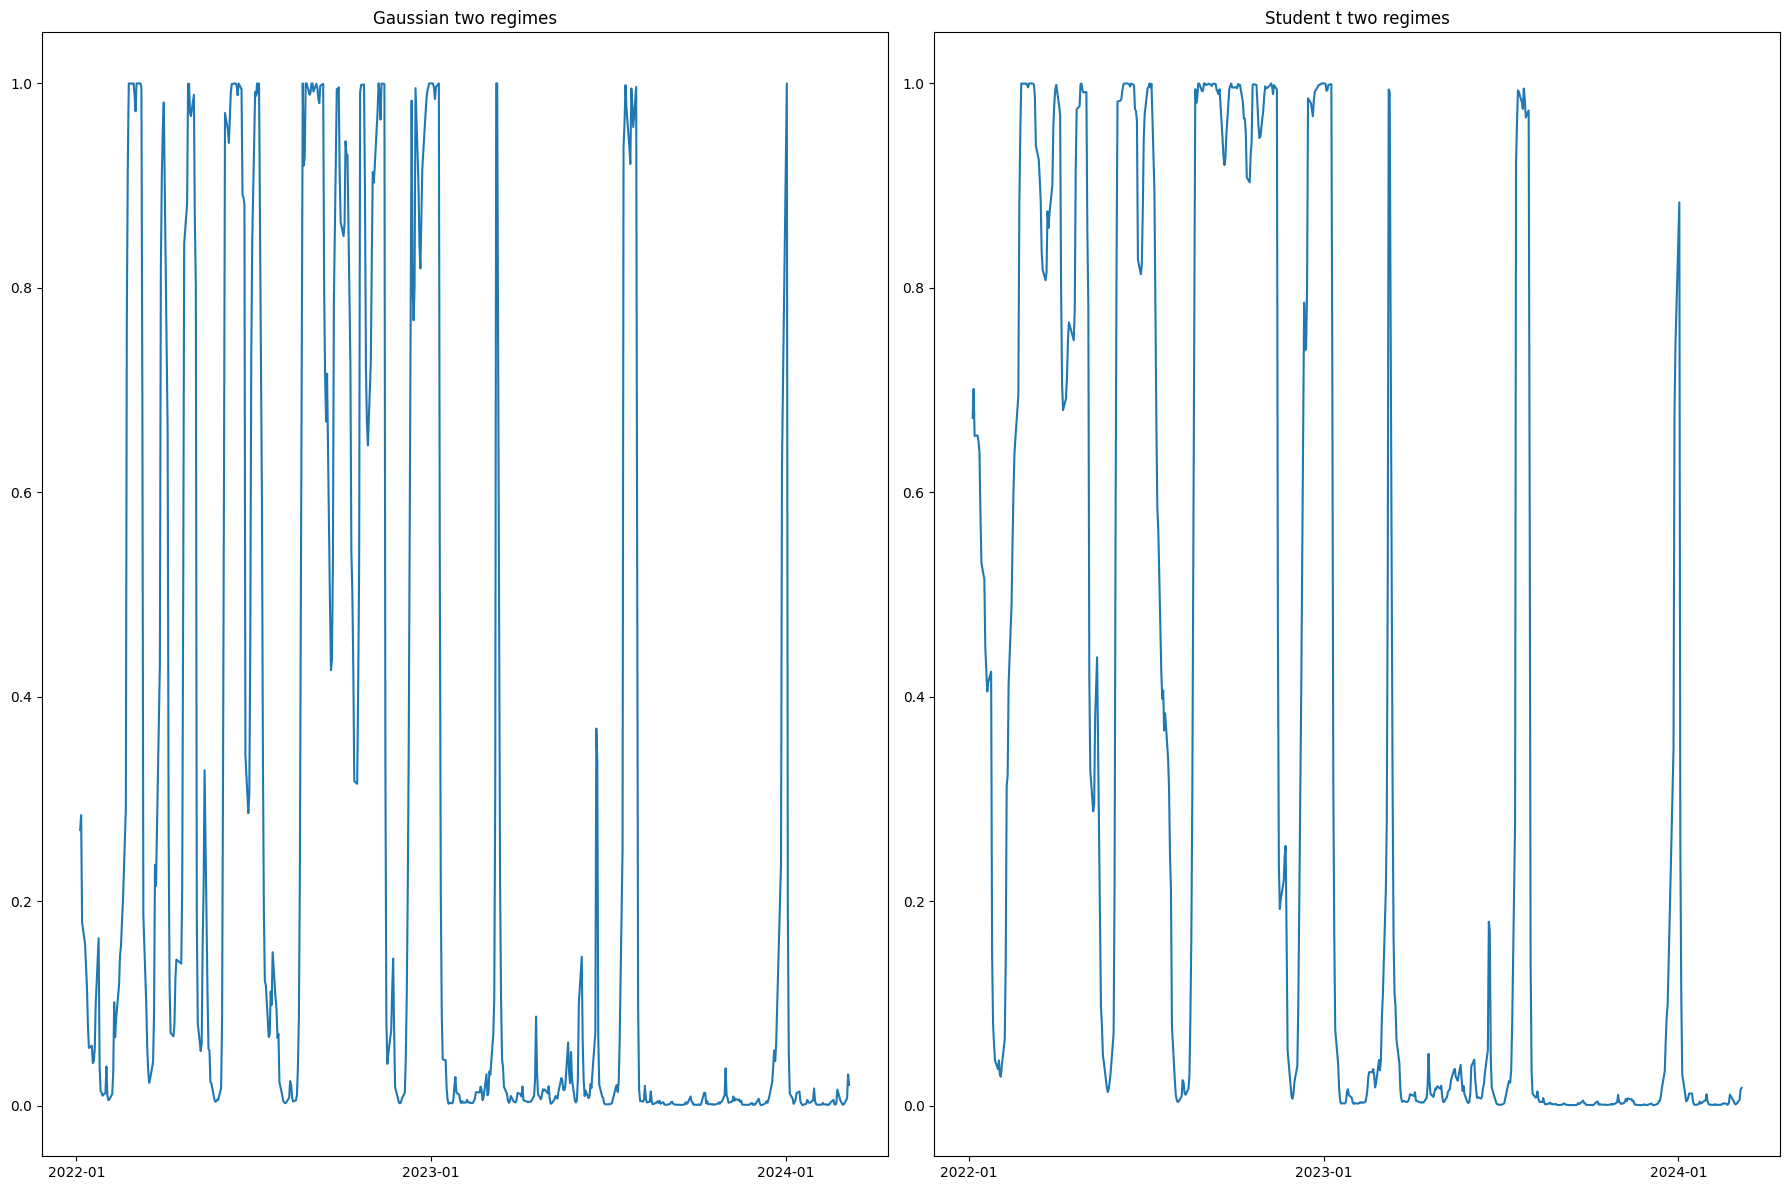

In [81]:
fig_2 = pt.figure_2(df_comms_ret[st_date:],chi_AR_norm,chi_AR_stu)
plt.show(fig_2)

# Figure 3

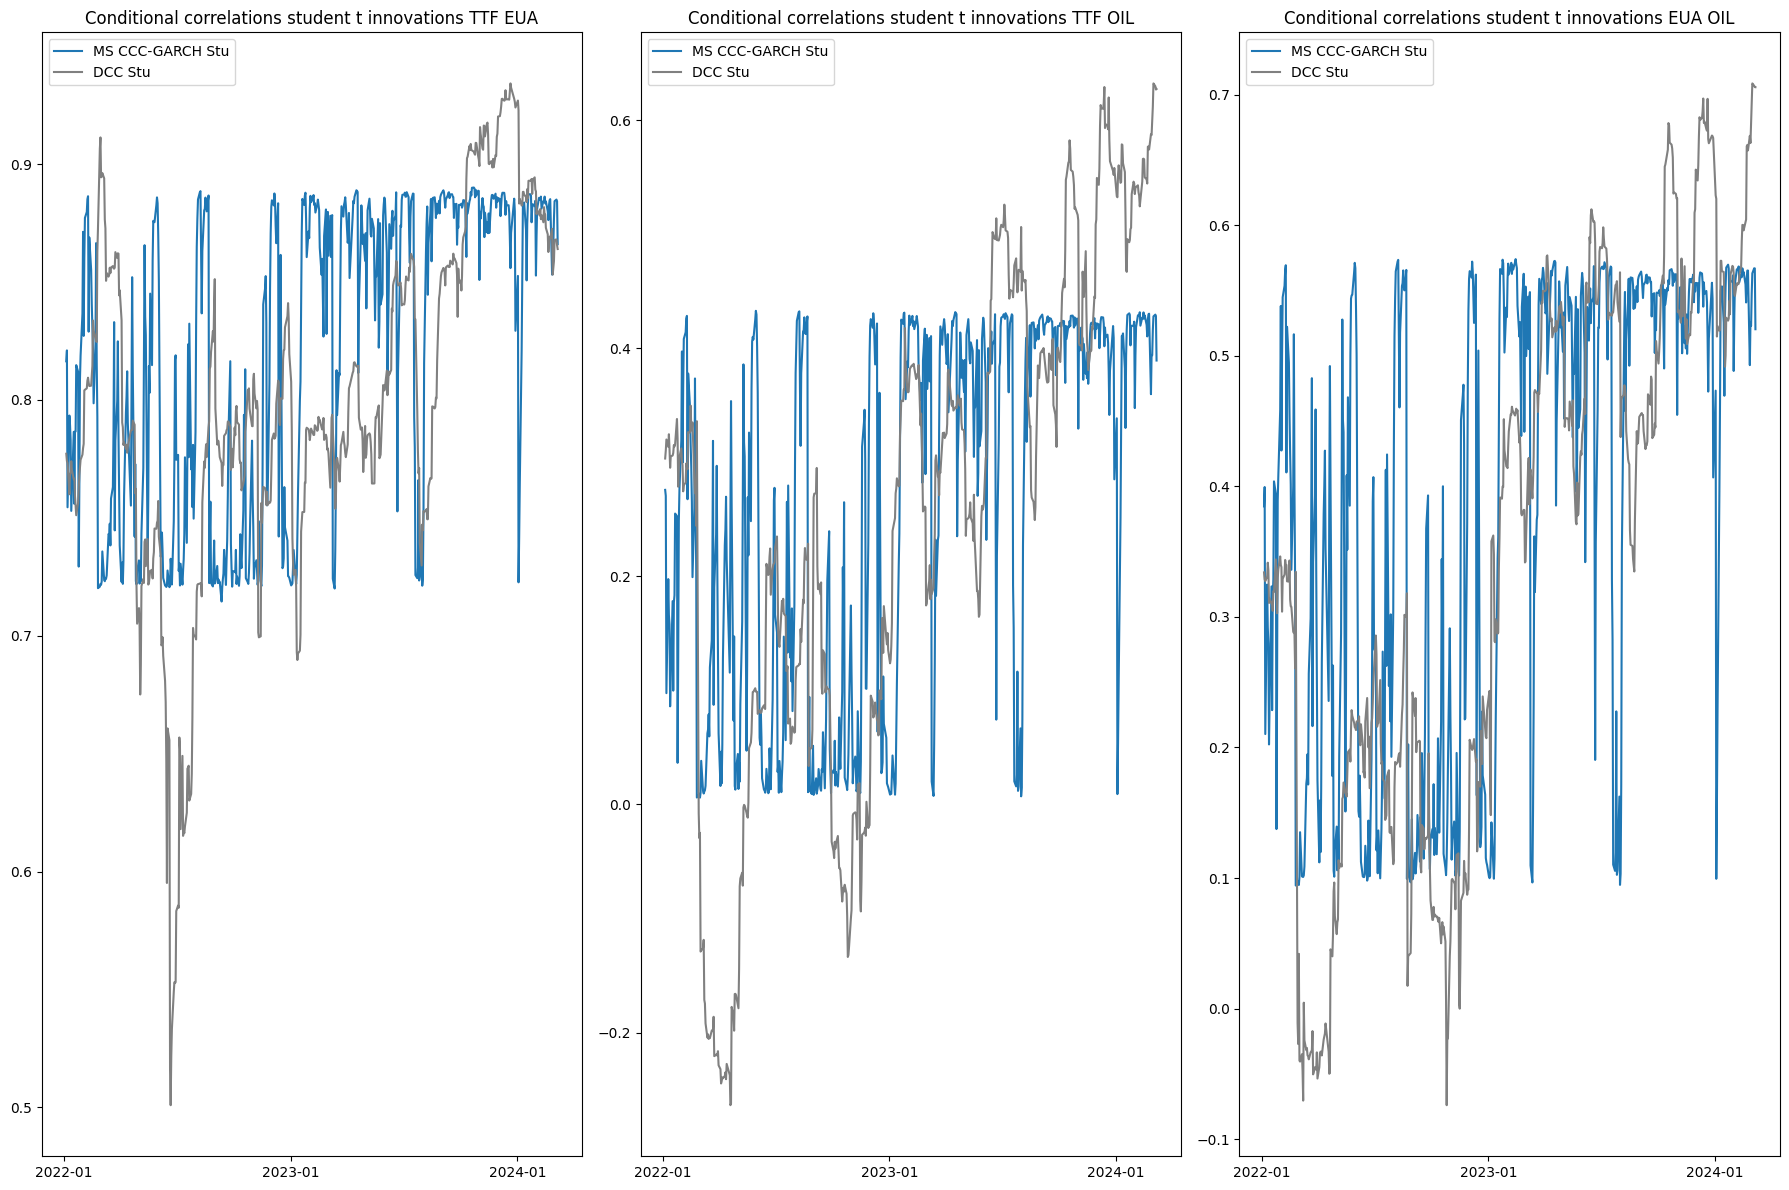

In [82]:
fig_3 = pt.figure_3(df_comms_ret[st_date:],condcorr_stu_ar,corrstudcc)
plt.show(fig_3)

# LR Test Tables 4 and 5 

LR tests conducted individually, tables shown in paper constructed manually 


## LRT regimes

Norm 2 vs Norm 1

In [106]:
ut.LRT_test(loglik_no_mean_norm, mgarch_single_norm.loglik,res_no_mean_norm.x,res_single_norm.x)

{'LRT': array([[230.97874341]]), 'p_value': array([[0.]])}

Note: when tested it appears that norm single model can get -inf solution without code failing. in such case estimation of single model must be re run.

Stu 2 vs Stu 1 

In [113]:
ut.LRT_test( loglik_no_mean_stu, mgarch_single_stu.loglik,res_no_mean_stu.x,res_single_stu.x)

{'LRT': array([[117.48868144]]), 'p_value': array([[0.]])}

Norm 3 vs Norm 2

In [114]:
ut.LRT_test( loglik_3_norm, loglik_no_mean_norm,res_no_mean_norm_3.x,res_no_mean_norm.x)

{'LRT': array([[30.15636055]]), 'p_value': array([[0.01720814]])}

Stu 3 vs Stu 2

In [115]:
ut.LRT_test( loglik_3_stu, loglik_no_mean_stu,res_no_mean_stu_3.x,res_no_mean_stu.x)

{'LRT': array([[13.09227383]]), 'p_value': array([[0.6659994]])}

## LRT mean spec

### no mean norm vs mean norm

In [116]:
ut.LRT_test( -(res_mean_norm.fun * ret_arr_gpe.shape[0]), loglik_no_mean_norm,res_mean_norm.x,res_no_mean_norm.x)

{'LRT': array([[5.40274747]]), 'p_value': array([[0.1445725]])}

### no mean norm vs AR norm

In [117]:
ut.LRT_test( -(res_AR_norm.fun * ret_arr_gpe.shape[0]), loglik_no_mean_norm,res_AR_norm.x,res_no_mean_norm.x)

{'LRT': array([[14.20287114]]), 'p_value': array([[0.00264162]])}

### no mean stu vs mean stu

In [118]:
ut.LRT_test( -(res_mean_stu.fun * ret_arr_gpe.shape[0]), loglik_no_mean_stu,res_mean_stu.x,res_no_mean_stu.x)

{'LRT': array([[2.7420151]]), 'p_value': array([[0.43313442]])}

### no mean stu vs AR stu

In [119]:
ut.LRT_test( -(res_AR_stu.fun * ret_arr_gpe.shape[0]), loglik_no_mean_stu,res_AR_stu.x,res_no_mean_stu.x)

{'LRT': array([[13.64257367]]), 'p_value': array([[0.00343434]])}

### no mean skewed t vs mean skewed t 

In [120]:
ut.LRT_test( -(res_mean_skewed_t.fun * ret_arr_gpe.shape[0]), loglik_skewed_t,res_mean_skewed_t.x,res_no_mean_skewed_t.x)

{'LRT': array([[1.43076423]]), 'p_value': array([[0.69833953]])}

### no mean skewed t vs AR skewed t 

In [121]:
ut.LRT_test( -(res_AR_skewed_t.fun * ret_arr_gpe.shape[0]), loglik_skewed_t,res_AR_skewed_t.x,res_no_mean_skewed_t.x)

{'LRT': array([[13.19785044]]), 'p_value': array([[0.0042277]])}

# VaR test

In [122]:
df_backtest = df_comms_ret['2020-10-01':]

next cells include backtest of 1 period ahead var estimation. resuts of models rolling window fit re estimation stored in folders fcst_***

In [123]:
import os
from tqdm import tqdm 

window_size = 550
n = 3
h = 1

f_end = 250
mu_list = []

w_list = []

date = []
var_list_stu_dcc =  []

ones = np.ones(n)
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_dcc_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        stu_dcc = dcc(ret = ret_temp,dist = 't')
    else:
        stu_dcc = dcc(ret = ret_temp,dist = 't')


    Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu =  stu_dcc.tdccfore(res_temp)
    dcc_fore  =  stu_dcc.dccsim(Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu, 1)
    cov_m = np.reshape(dcc_fore[:,0], (3, 3))
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:]

            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_dcc.append(portfolio_var)
            
        else:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_dcc.append(portfolio_var)


  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:05<00:00, 44.51it/s]


In [124]:
window_size = 550
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

w_list = []

date = []
var_list_stu =  []
rret_short = []
rret_long = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    d = i + h
    weights_long = np.array([0.33,0.33,0.33])
    weights_short = np.array([-0.33,-0.33,-0.33])
    
    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = (res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1)
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:].iloc[0]

            rret_short.append(ret_pnl.values @ weights_short.T)
            rret_long.append(ret_pnl.values @ weights_long.T)
            
            var_list_stu.append(portfolio_var)
            
        else:
            mu = (res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values - res_temp[:n] ) * phi1)

            alpha = 0.95

            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.t.ppf(alpha, df=nu)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            

            rret_short.append(ret_pnl.values @ weights_short.T)
            rret_long.append(ret_pnl.values @ weights_long.T)
            var_list_stu.append(portfolio_var)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:33<00:00,  7.50it/s]


In [125]:
# VaR MS CCC-GARCH Norm

window_size = 550
n = 3
h = 1

f_end = 250

var_list_norm =  []
rret = []


for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_norm/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_norm_ar = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_norm_ar = mgarch(dist='norm',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)


    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_norm_ar.get_smoothed_prob(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_norm_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = mgarch_norm_ar.forecasts_norm(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit, h)   
    cov_m = condcov[-1]
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = (res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1)
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:].iloc[0]
            

            pnl_d = ret_pnl.values @ weights.T
            rret.append(pnl_d)
            var_list_norm.append(portfolio_var)
            
        else:
            mu = (res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values - res_temp[:n] ) * phi1)

            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))* scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            
            pnl_d = ret_pnl.values @ weights.T
            rret.append(pnl_d)
            var_list_norm.append(portfolio_var)

100%|██████████| 250/250 [00:28<00:00,  8.80it/s]


In [126]:
# VaR MS CCC-GARCH Skewed t

condcov_l, condcorr_l  = [],[]
window_size = 550
n = 3
h = 1

f_end = 250

var_list_stu_skewed_t_5 =  []
var_list_stu_skewed_t_95 =  []

np.random.seed(777)

ones = np.ones(n)
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skew_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar_skew_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skew_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = ut.skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,n,N = 3000,T=1)

    weights = np.array([-0.33,-0.33,-0.33])
    weights_m = weights[:, np.newaxis, np.newaxis]
    # Calculate weighted returns and sum across the assets dimension
    portfolio_returns = np.sum(Rt * weights_m, axis=0)

    # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
    portfolio_returns = np.sort(portfolio_returns.flatten())  # Flatten to 1D and sort

    # Calculate the 5th percentile (VaR at 95% confidence level)
    VaR_05 = np.percentile(portfolio_returns, 5)
    VaR_95 = np.percentile(portfolio_returns, 95)

    var_list_stu_skewed_t_5.append(VaR_05)
    var_list_stu_skewed_t_95.append(VaR_95)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [07:06<00:00,  1.71s/it]


In [127]:
window_size = 550
n = 3
h = 1

f_end = 250

var_list_stu_single = []

ones = np.ones(n)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_single_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp, init_params=res_temp)
    else:
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp)

    sinit,mu, w, A, B, G, R,nu = mgarch_single_stu.stusinglefore(res_temp)

    cov_m = mgarch_single_stu.forecast_single_stu(w, A, B, G, R, sinit,nu, 1)

    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            mu = res_temp[:n]
            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights))) * scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end].iloc[-h:]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_single.append(portfolio_var)
            
        else:
            mu = res_temp[:n]

            alpha = 0.95
            weights= np.array([-0.33,-0.33,-0.33])
            portfolio_var = np.dot(mu, weights) + np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))* scipy.stats.norm.ppf(alpha)
            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            var_list_stu_single.append(portfolio_var)

100%|██████████| 250/250 [00:06<00:00, 38.68it/s]


# Figure 4 VaR estimates

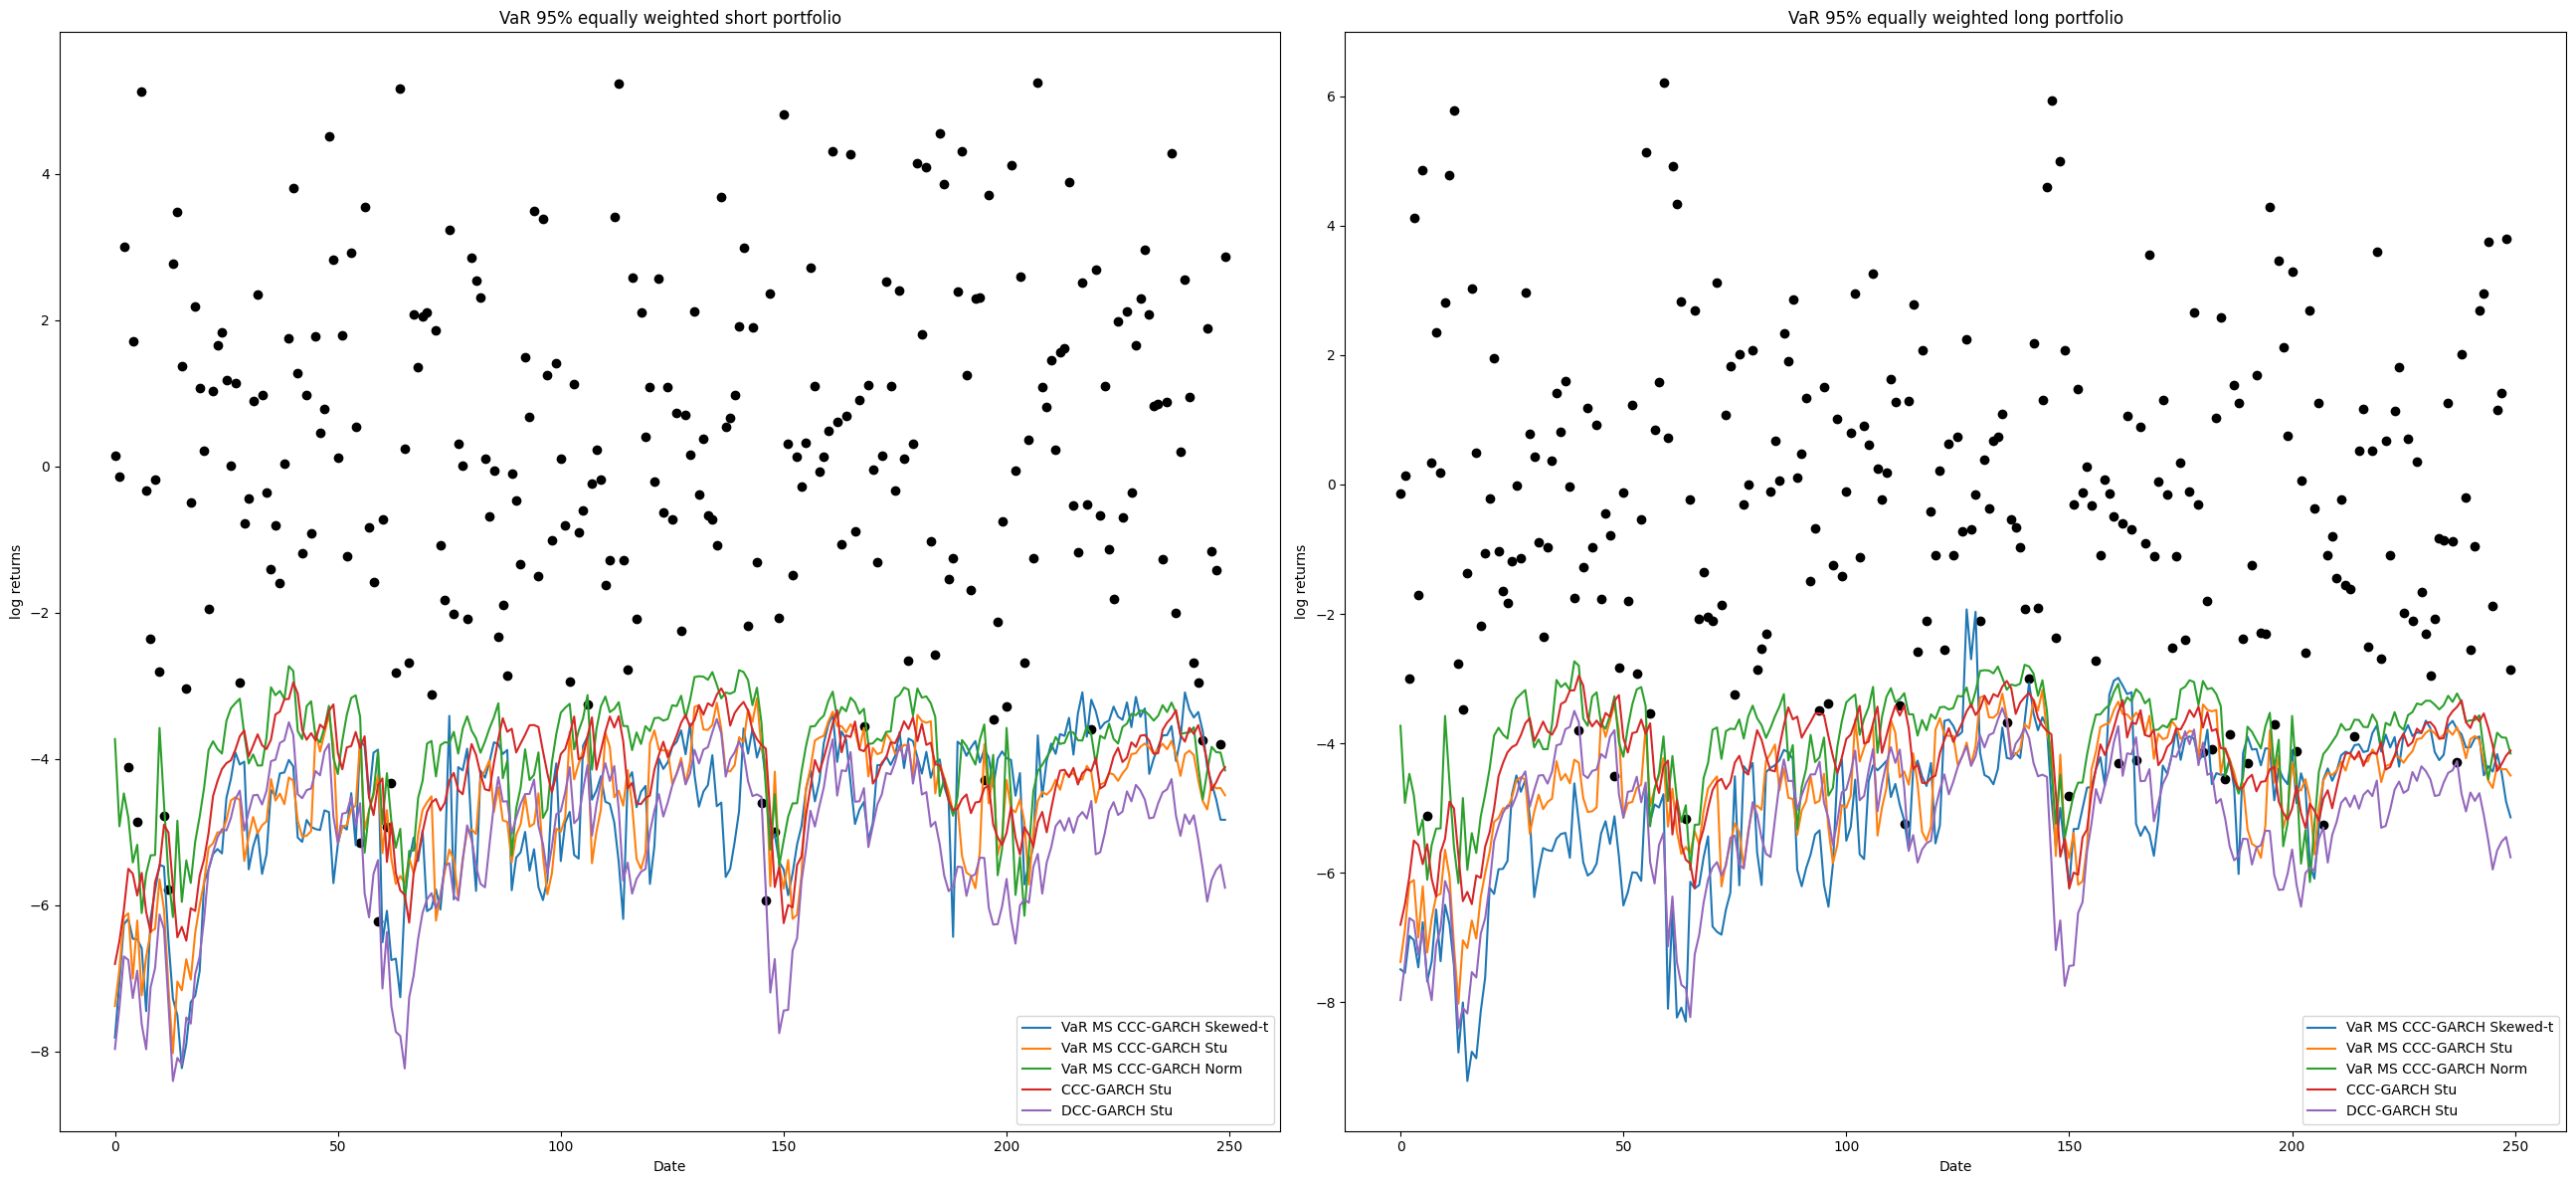

In [129]:
fig_4 = pt.figure_4(var_list_stu_skewed_t_5,var_list_stu_skewed_t_95,var_list_stu,
             var_list_norm,var_list_stu_single,var_list_stu_dcc,rret_short,rret_long)
plt.show(fig_4)

# Table 11

### Short

In [130]:
violations_stu = (np.array([x*-1 for x in var_list_stu]) > rret_short).astype(int)
violations_stu_dcc = (np.array([x*-1 for x in var_list_stu_dcc]) > rret_short).astype(int)
violations_norm = (np.array([x*-1 for x in var_list_norm]) > rret_short).astype(int)
violations_skew = (np.array([x for x in var_list_stu_skewed_t_5]) > rret_short).astype(int)
violations_stu_single = (np.array([x*-1 for x in var_list_stu_single]) > rret_short).astype(int)

In [131]:
ut.var_table([violations_stu_single,violations_norm,violations_stu,violations_skew,violations_stu_dcc])

Failure rate of 2.0%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 4.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.8%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.8%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 1.6%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


,Violation ratio,Kupiec,Christoffersen
0,0.02,0.01,0.34
0,0.04,0.66,0.36
0,0.03,0.08,0.06
0,0.03,0.08,0.64
0,0.02,0.00,0.13


### long

In [133]:
long_violations_stu = (np.array([x*-1 for x in var_list_stu]) > rret_long).astype(int)
long_violations_stu_dcc = (np.array([x*-1 for x in var_list_stu_dcc]) > rret_long).astype(int)
long_violations_norm = (np.array([x*-1 for x in var_list_norm]) > rret_long).astype(int)
long_violations_skew = (np.array([x*-1 for x in var_list_stu_skewed_t_95]) > rret_long).astype(int)
long_violations_stu_single = (np.array([x*-1 for x in var_list_stu_single]) > rret_long).astype(int)

In [96]:
ut.var_table([long_violations_stu_single,long_violations_norm,long_violations_stu,long_violations_skew,long_violations_stu_dcc])

Failure rate of 4.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 6.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 4.0%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 2.4%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL
Failure rate of 3.2%
CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL


,Violation ratio,Kupiec,Christoffersen
0,0.04,0.66,0.83
0,0.06,0.33,0.87
0,0.04,0.45,0.93
0,0.02,0.04,0.93
0,0.03,0.16,0.45


## Table 10 Engele-Colacito GMVP test

In [135]:
window_size = 550
n = 3
h = 1
f_end = 300

In [136]:
portfolio_ret_msgarch_norm = []

ones = np.ones(n)
res_fix = res_AR_norm.x
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_norm/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_fix)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_fix)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_norm.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_norm.append(pnl_d)

100%|██████████| 300/300 [00:37<00:00,  8.03it/s]


In [137]:
portfolio_ret_dcc = []

res_fix = estdcct.x

for i in tqdm(range(0,f_end,h)):
    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    filename = f'fcst_dcc_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        stu_dcc = dcc(ret = ret_temp,dist = 't')
    else:
        stu_dcc = dcc(ret = ret_temp,dist = 't')

    Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu =  stu_dcc.tdccfore(res_fix)
    dcc_fore  =  stu_dcc.dccsim(Q, R, h_dcc, S, w, A, B, G, alpha, beta, nu, 1)
    cov_m = np.reshape(dcc_fore[:,0], (3, 3))
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_dcc.append(pnl_d)
        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)


            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_dcc.append(pnl_d)


  0%|          | 0/300 [00:00<?, ?it/s]

100%|██████████| 300/300 [00:06<00:00, 46.09it/s]


In [139]:

portfolio_ret_msgarch_stu = []

ones = np.ones(n)

res_fix = res_AR_stu.x
for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,)

        
    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.get_smoothed_prob(res_fix)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_fix)
    sigmafore, condcov, condcorr  = mgarch_gpe_ar.forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_stu.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)
            # Ones vector
            ones = np.ones(len(cov_m))
            # Calculate gmvp weights
            w_gmvp = inv_cov_matrix @ ones / (ones.T @ inv_cov_matrix @ ones)

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_msgarch_stu.append(pnl_d)



 21%|██        | 62/300 [00:08<00:33,  7.14it/s]

In [119]:
def forecastssingle_stu(w, A, B, G, R, sinit,nu, D):
    Atilde = A * G
    Rtilde = 2 / np.pi * (R * np.arcsin(R) + np.sqrt(1 - R ** 2))
    kappa1 = np.sqrt(nu-2)/np.sqrt(np.pi)*exp(scipy.special.loggamma((nu-1)/2)-scipy.special.loggamma(nu/2))
    Y = np.concatenate([sinit, np.ravel(np.outer(sinit, sinit))]).reshape(-1, 1) 

    C11 = kappa1 * A + B
    C21 = np.kron(w, C11) + np.kron(C11, w)
    C22 = np.kron(B, B) + kappa1 * (np.kron(B, A) + np.kron(A, B)) + np.kron(A, A) @ np.diag(np.ravel(Rtilde)) + \
        np.kron(Atilde, Atilde) @ np.diag(np.ravel(R))
    Ctilde = np.block([[C11, np.zeros((1*3,1 * 3**2))], [C21, C22]])
    wtilde = np.concatenate([w, np.kron(w, w)])

    sigmafore = np.zeros((3, 3, D))
    sigmafore[:, :, 0] = R * np.reshape(Y[3:], (3, 3))

    for d in range(1, D):
        Y = wtilde + Ctilde @ Y
        sigmafore[:, :, d] = R * np.reshape(Y[3:], (3, 3))

    sigmalong = np.sum(sigmafore, axis=2)
    
    return sigmalong

In [120]:
window_size = 550
n = 3
h = 1
f_end = 300

portfolio_ret_single_stu = []

res_fix = res_single_stu.x
ones = np.ones(n)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_single_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp, init_params=res_temp)
    else:
        mgarch_single_stu = mgarch_single(dist='t',ret = ret_temp)
        '''res_temp = mgarch_single_stu.fit()
        pd.to_pickle(res_temp.x,filename)
        res_temp = res_temp.x'''

    sinit,mu, w, A, B, G, R,nu = mgarch_single_stu.stusinglefore(res_fix)

    cov_m = mgarch_single_stu.forecast_single_stu(w, A, B, G, R, sinit,nu, 1)
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            inv_cov_matrix = np.linalg.inv(cov_m)  # Inverse of the covariance matrix
            w_gmvp = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_single_stu.append(pnl_d)

        else:
            inv_cov_matrix = np.linalg.inv(cov_m)  # Inverse of the covariance matrix
            w_gmvp = inv_cov_matrix.dot(ones) / ones.dot(inv_cov_matrix).dot(ones)


            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            
            pnl_d = ret_pnl.values @ w_gmvp.T
            portfolio_ret_single_stu.append(pnl_d)

100%|██████████| 300/300 [00:05<00:00, 50.02it/s]


In [124]:
np.sum(np.square(portfolio_ret_msgarch_stu[:])-np.square(portfolio_ret_single_stu[:]))

-62.397587788547185

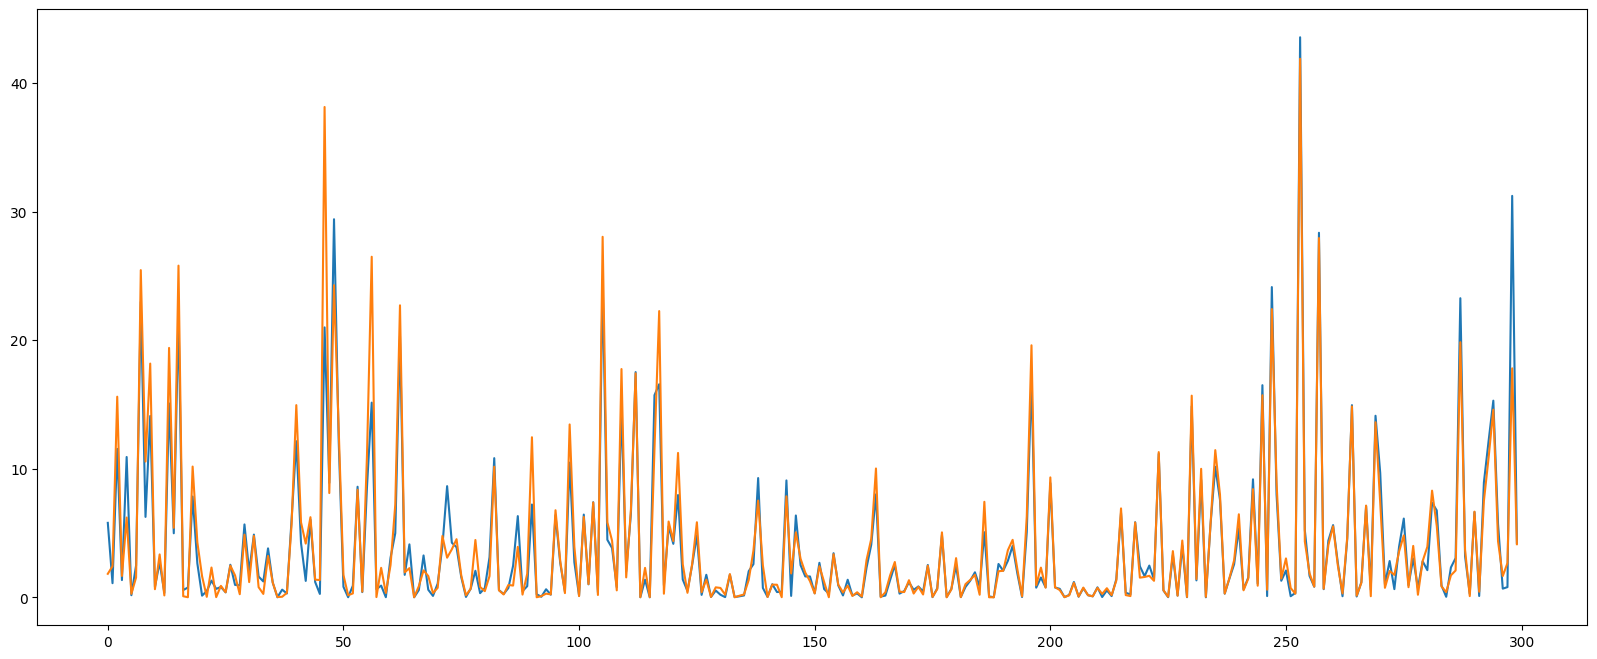

In [125]:
plt.figure(figsize=(20,8))
plt.plot(np.square(portfolio_ret_msgarch_stu[:]))
plt.plot(np.square(portfolio_ret_single_stu[:]))

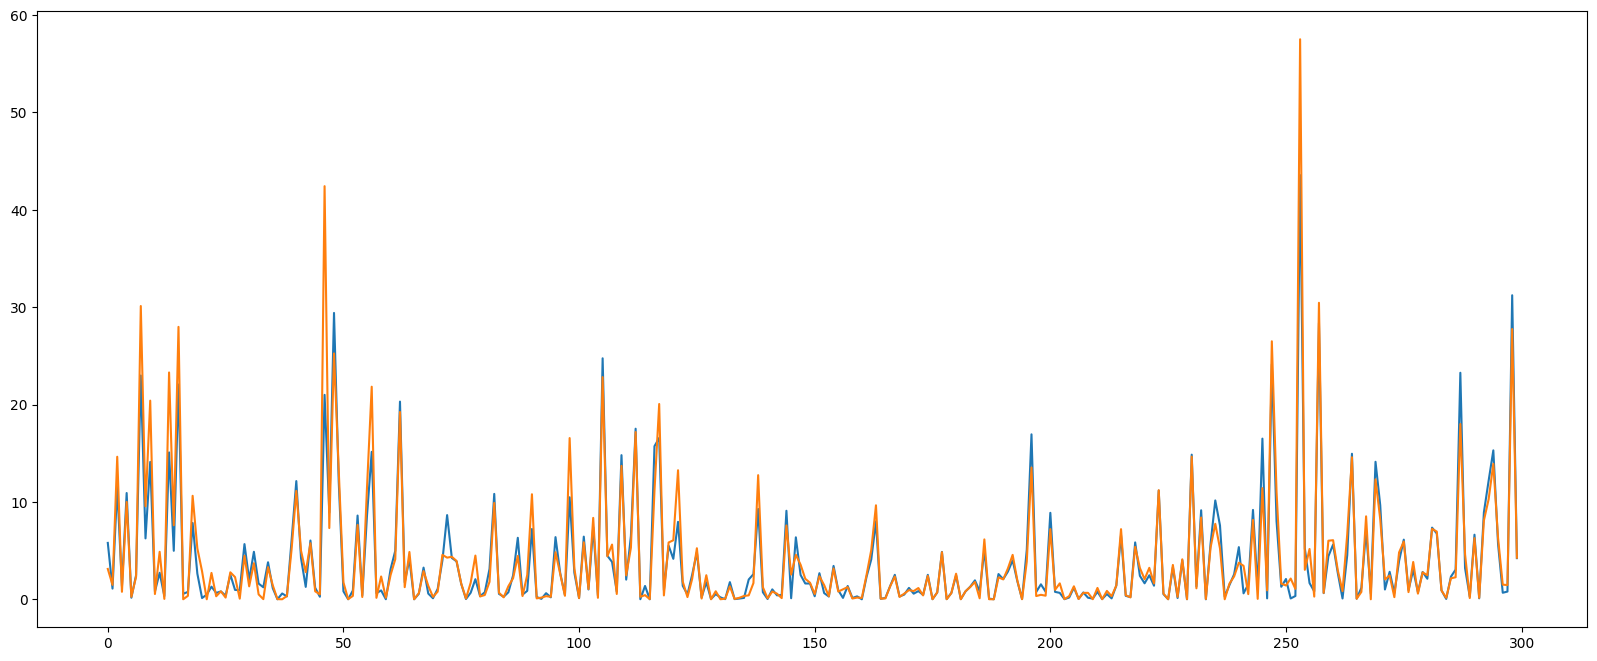

In [126]:
plt.figure(figsize=(20,8))
plt.plot(np.square(portfolio_ret_msgarch_stu[:]))
plt.plot(np.square(portfolio_ret_dcc[:]))

In [80]:
import statsmodels.api as sm
import numpy as np

list_ret = [
    portfolio_ret_single_stu[:],
    portfolio_ret_msgarch_norm[:],
    portfolio_ret_msgarch_stu[:],
    portfolio_ret_dcc[:]
]

# Initialize matrices to store coefficients and p-values
n = len(list_ret)
coef_matrix = np.zeros((n, n))
p_value_matrix = np.zeros((n, n))

# Perform pairwise regressions and fill the matrices
for i in range(n):
    for j in range(n):
        if i != j:
            # Compute the squared differences
            Y = np.square(list_ret[i]) - np.square(list_ret[j])
            X = np.ones(len(list_ret[j]))
            # Create and fit the model
            model = sm.OLS(Y, X)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
            # Store the coefficient and p-value
            coef_matrix[i, j] = results.params[0]
            p_value_matrix[i, j] = results.pvalues[0]

# Print matrices
print("Coefficient Matrix:")
print(coef_matrix *-1)
print("\nP-Value Matrix:")
print(p_value_matrix)


Coefficient Matrix:
[[-0.          0.12894787 -0.2080082   0.05742468]
 [-0.12894787 -0.         -0.33695607 -0.07152319]
 [ 0.2080082   0.33695607 -0.          0.26543288]
 [-0.05742468  0.07152319 -0.26543288 -0.        ]]

P-Value Matrix:
[[0.         0.35134606 0.06086042 0.5568823 ]
 [0.35134606 0.         0.02349111 0.69464959]
 [0.06086042 0.02349111 0.         0.03436157]
 [0.5568823  0.69464959 0.03436157 0.        ]]


In [127]:
import statsmodels.api as sm
import numpy as np

list_ret = [
    portfolio_ret_single_stu[:],
    portfolio_ret_msgarch_norm[:],
    portfolio_ret_msgarch_stu[:],
    portfolio_ret_dcc[:]
]

# Initialize matrices to store coefficients and p-values
n = len(list_ret)
coef_matrix = np.zeros((n, n))
p_value_matrix = np.zeros((n, n))

# Perform pairwise regressions and fill the matrices
for i in range(n):
    for j in range(n):
        if i != j:
            # Compute the squared differences
            Y = np.square(list_ret[i]) - np.square(list_ret[j])
            X = np.ones(len(list_ret[j]))
            # Create and fit the model
            model = sm.OLS(Y, X)
            results = model.fit(cov_type='HAC', cov_kwds={'maxlags': 1})
            # Store the coefficient and p-value
            coef_matrix[i, j] = results.params[0]
            p_value_matrix[i, j] = results.pvalues[0]

# Print matrices
print("Coefficient Matrix:")
print(coef_matrix *-1)
print("\nP-Value Matrix:")
print(p_value_matrix)


Coefficient Matrix:
[[-0.          0.12896411 -0.20799196  0.05744136]
 [-0.12896411 -0.         -0.33695607 -0.07152275]
 [ 0.20799196  0.33695607 -0.          0.26543332]
 [-0.05744136  0.07152275 -0.26543332 -0.        ]]

P-Value Matrix:
[[0.         0.35128313 0.06086865 0.55676126]
 [0.35128313 0.         0.02349111 0.69464607]
 [0.06086865 0.02349111 0.         0.03436326]
 [0.55676126 0.69464607 0.03436326 0.        ]]


# Portfolio

In [97]:
df_backtest = df_comms_ret['2020-10-01':end_date]

In [98]:
def forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G1, G2, sigma1init, sigma2init, pinit,nu, D):

    def cov_to_corr(cov_matrix):
        n = cov_matrix.shape[0]
        corr_matrix = np.zeros_like(cov_matrix)
        
        for i in range(n):
            for j in range(n):
                corr_matrix[i, j] = cov_matrix[i, j] / np.sqrt(cov_matrix[i, i] * cov_matrix[j, j])
                
        return corr_matrix


    pinit = np.array(pinit).reshape(-1, 1)
    Xinit = np.array([sigma1init, sigma2init]).ravel().reshape(-1, 1)
    XXinit = (Xinit @ Xinit.T).reshape(-1,1)
    Yinit = np.concatenate((Xinit, XXinit))

    kappa1 = np.sqrt(nu-2)/np.sqrt(np.pi)*exp(scipy.special.loggamma((nu-1)/2)-scipy.special.loggamma(nu/2))
    M = len(w1)
    R1.shape[0]
    k = P.shape[0]

    p = P[0, 0]
    q = P[1, 1]


    omega = np.vstack((w1, w2))
    A = np.vstack((A1, A2))
    Atilde = np.vstack((A1 * G1, A2 * G2))
    B = np.block([[B1, np.zeros((M, M))], [np.zeros((M, M)), B2]])

    Gam = np.zeros((M*M, M*M, 2))
    Gam[:, :, 0] = np.diag((2 / np.pi * (R1* np.arcsin(R1) + np.sqrt(1 - R1 ** 2))).reshape(1,-1)[0])
    Gam[:, :, 1] = np.diag((2 / np.pi * (R2* np.arcsin(R2) + np.sqrt(1 - R2 ** 2))).reshape(1,-1)[0])


    R = np.zeros((M, M, 2))
    G = np.zeros((M, M, 2))
    e = np.eye(2)

    R[:, :, 0] = R1
    R[:, :, 1] = R2
    G[:, :, 0] = G1
    G[:, :, 1] = G2

    R1tilde = np.vstack((np.hstack((R1,R1)), np.hstack((R1,R1))))
    R2tilde = np.vstack((np.hstack((R2,R2)), np.hstack((R2,R2))))
    Gam1tilde = np.diag(np.ravel(R1tilde))
    Gam2tilde = np.diag(np.ravel(R2tilde))


    Pgamtilde = np.vstack((np.hstack((p * Gam1tilde, (1 - q) * Gam1tilde)),np.hstack(((1 - p) * Gam2tilde, q * Gam2tilde))))

    C11 = np.zeros((M*k, M*k, k))
    C21 = np.zeros((k**2 * M**2, k * M, k))
    C22 = np.zeros((k**2 * M**2, k**2 * M**2, k))
    Ctilde = np.zeros((k**2 * M**2 + k*M, k**2 * M**2+ k*M, k))

    for j in range(k):
        C11[:, :, j] = kappa1 * (A @ np.kron(e[j, :], np.eye(M))) + B
        C21[:, :, j] = np.kron(omega, C11[:, :, j]) + np.kron(C11[:, :, j], omega)
        C22[:, :, j] = (np.kron(A, A) @ Gam[:, :, j] + np.kron(Atilde, Atilde) @ np.diag(np.ravel(R[:, :, j]))) @ np.kron(np.kron(e[j, :], np.eye(M)), np.kron(e[j, :], np.eye(M))) + \
        kappa1 * (np.kron(np.kron(e[j, :], A), B) + np.kron(B, np.kron(e[j, :], A))) + \
        np.kron(B, B)
        Ctilde[:, :, j] = np.block([[C11[:, :, j], np.zeros((k*M,k**2 * M**2))], [C21[:, :, j], C22[:, :, j]]])

    PCtilde = np.block([[p*Ctilde[:,:,0],(1-q)*Ctilde[:,:,0]],[(1-p)*Ctilde[:,:,1],q*Ctilde[:,:,1]]])
    omegatilde = np.vstack((omega,np.kron(omega,omega)))

    II = np.kron(np.eye(k), np.concatenate((np.zeros((k**2 * M**2, k * M)), np.eye(k**2 * M**2)), axis=1))
    Ytilde = np.zeros((Yinit.shape[0] * 2 , D))
    Ytilde[:, 0] = np.kron(pinit, Yinit).reshape(1,-1)

    sigmafore = np.zeros((M*M , D))

    condcorr = np.eye(M) * np.expand_dims(zeros([M,D]).T, axis=2)
    condcov = np.eye(M) * np.expand_dims(zeros([M,D]).T, axis=2)

    sigmafore[:, 0] = (np.kron(e[0, :], np.kron(np.kron(e[0, :], np.eye(M)), np.kron(e[0, :], np.eye(M)))) +
                    np.kron(e[1, :], np.kron(np.kron(e[1, :], np.eye(M)), np.kron(e[1, :], np.eye(M))))).dot(Pgamtilde).dot(II).dot(Ytilde[:, 0])
    C = np.reshape(sigmafore[:, 0], (M, M))
    condcorr[0] = cov_to_corr(C)
    condcov[0] = C
    prob = pinit

    for d in range(1, D):
        prob = np.dot(P, prob)
        Ytilde[:, d] = (np.kron(prob, omegatilde) + PCtilde @ Ytilde[:, d-1].reshape(-1,1)).flatten()
        temp = np.dot(np.dot(Pgamtilde, II), Ytilde[:, d])
        sigmafore[:, d] = (np.kron(e[0, :], np.kron(np.kron(e[0, :], np.eye(M)), np.kron(e[0, :], np.eye(M)))) +
                    np.kron(e[1, :], np.kron(np.kron(e[1, :], np.eye(M)), np.kron(e[1, :], np.eye(M))))).dot(temp)
        C = np.reshape(sigmafore[:, d], (M, M))
        condcorr[d] = cov_to_corr(C)
        condcov[d] = C
    
    return sigmafore, condcov, condcorr


In [99]:
import numpy as np
def calculate_variance(ER_list, A, E, h):
    variance = 0 
    for i in range(1, h+1):
        variance +=  E.T @ ER_list[i-1] @ E
    for i in range(2, h+1):
        for j in range(1, i):
            variance += E.T @ np.linalg.matrix_power(A, i-j) @ ER_list[j-1] @ E
    for i in range(1, h):
        for j in range(i+1, h+1):
            variance += E.T @ ER_list[i-1] @ np.linalg.matrix_power(A, j-i).T @ E
    return variance


## short only

In [100]:
import os
from tqdm import tqdm 
from IPython.display import display, clear_output
import time 

condcov_l, condcorr_l  = [],[]
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_gmvp = []

w_list = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            mu = res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                return vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl_gmvp = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_gmvp_d = ret_pnl_gmvp.values @ weights.T
            pnl_gmvp.append(pnl_gmvp_d)

        else:
            mu = res_temp[:n]+ (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))

                return vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl_gmvp = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_gmvp_d = ret_pnl_gmvp.values @ weights.T
            pnl_gmvp.append(pnl_gmvp_d)



  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:30<00:00,  8.19it/s]


In [101]:
import os
from tqdm import tqdm 
from IPython.display import display, clear_output
import time 

condcov_l, condcorr_l  = [],[]
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_sharpe = []

w_list = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp,init_params=res_temp)

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)
    sigmafore, condcov, condcorr  = forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    cov_m = condcov[-1]
    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            mu = res_temp[:n]+ (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                return -ret/vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl_sharpe = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_d = ret_pnl_sharpe.values @ weights.T
            pnl_sharpe.append(pnl_sharpe_d)

        else:
            mu = res_temp[:n]+ (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))

                return -ret/vol

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(get_ret_vol_sr, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl_sharpe = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_sharpe_d = ret_pnl_sharpe.values @ weights.T
            pnl_sharpe.append(pnl_sharpe_d)



  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:29<00:00,  8.45it/s]


In [102]:
condcov_l, condcorr_l  = [],[]
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_equal = []

w_list = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    

    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 ==0:
            weights = np.array([-0.33, -0.33, -0.33])
            
            w_list.append(weights)

            ret_pnl_equal = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_equal_d = ret_pnl_equal.values @ weights.T
            pnl_equal.append(pnl_equal_d)
            mu_list.append(mu)

        else:
            
            init_guess = [-0.33, -0.33, -0.33]

            weights = np.array([-0.33, -0.33, -0.33])
            
            w_list.append(weights)

            ret_pnl_equal = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_equal_d = ret_pnl_equal.values @ weights.T
            pnl_equal.append(pnl_equal_d)
            mu_list.append(mu)



100%|██████████| 250/250 [00:00<00:00, 2652.30it/s]


In [139]:
window_size = 525
np.random.seed(777)
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_model_skew_short = []

w_list_cvar = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'

    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
    else:
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)


    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skewed_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,d = 3,N = 2000,T=1)
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            
            cons = (

            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1})
            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)

                # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_short.append(pnl_d)
            w_list_cvar.append(weights)
            
        else:
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1}
            )
            bounds = ((-1,0),(-1,0),(-1,0))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)

                # Assuming portfolio_returns is the array of shape (1, 1000) with portfolio returns for each simulation
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_short.append(pnl_d)
            w_list_cvar.append(weights)

100%|██████████| 250/250 [05:05<00:00,  1.22s/it]


In [140]:
average_return = np.mean(pnl_model_skew_short[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl_model_skew_short[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio,average_return,volatility

(1.4144294218859266, 0.17340787078490755, 1.9462014620695156)

In [141]:
average_return = np.mean(pnl_equal[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl_equal[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio

1.3403124664252788

In [142]:
average_return = np.mean(pnl_gmvp[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl_gmvp[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio

1.491373764526826

In [143]:
average_return = np.mean(pnl_sharpe[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl_sharpe[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio

1.7338569880558177

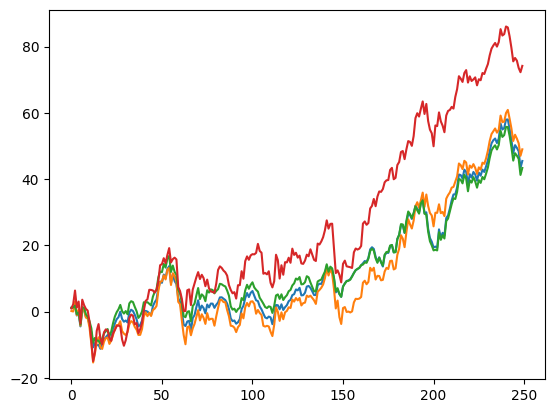

In [144]:
plt.plot(np.cumsum(pnl_gmvp[:]))
plt.plot(np.cumsum(pnl_equal[:]))
plt.plot(np.cumsum(pnl_model_skew_short[:]))
plt.plot(np.cumsum(pnl_sharpe[:]))

In [145]:
import numpy as np

def calculate_maximum_drawdown(pnl_vector):
    """
    Calculate the maximum drawdown in a PnL vector.

    Parameters:
    - pnl_vector: A numpy array or list containing the PnL values.

    Returns:
    - max_drawdown: The maximum drawdown value.
    """
    # Convert pnl_vector to a numpy array if it isn't one already
    pnl_vector = np.array(pnl_vector)

    # Calculate the running maximum
    running_max = np.maximum.accumulate(pnl_vector)

    # Calculate drawdown
    drawdown = running_max - pnl_vector

    # Find maximum drawdown
    max_drawdown = np.max(drawdown)

    return max_drawdown


In [134]:
def return_portfolio_stats(pnl_arr):
    average_return = np.mean(pnl_arr[:])
    # Calculate standard deviation of daily return
    volatility = np.std(pnl_arr[:])

    # Calculate Sharpe ratio
    sharpe_ratio = (252)**0.5*average_return / volatility
    df_ret = pd.DataFrame({
    'TR': [np.round(np.sum(pnl_arr),2)],
    'MR': [average_return],
    'Risk': [volatility],
    'SR': [sharpe_ratio],
    'MDD': [calculate_maximum_drawdown(pnl_arr)]
    }, index=[0])
    return df_ret.round(2)


In [135]:
return_portfolio_stats(pnl_equal)

,TR,MR,Risk,SR,MDD
0,48.98,0.2,2.32,1.34,11.34


In [136]:
return_portfolio_stats(pnl_gmvp)

,TR,MR,Risk,SR,MDD
0,45.46,0.18,1.94,1.49,10.51


In [137]:
return_portfolio_stats(pnl_sharpe)

,TR,MR,Risk,SR,MDD
0,74.17,0.3,2.72,1.73,15.6


In [138]:
return_portfolio_stats(pnl_model_skew_short)

,TR,MR,Risk,SR,MDD
0,43.1,0.17,1.96,1.4,10.61


## long short

In [146]:
import os
from tqdm import tqdm 
from IPython.display import display, clear_output
import time 

condcov_l, condcorr_l  = [],[]
window_size = 550
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl = []
pnl_gas = []
pnl_eua = []
pnl_pow = []
w_list = []

date = []

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')
    
    filename = f'fcst_ar_stu/res_{tstamp}.pkl'
    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp, init_params=res_temp)
    else:
        mgarch_gpe_ar = mgarch(dist='t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
        '''res_temp = mgarch_gpe_ar.fit()
        pd.to_pickle(res_temp.x,filename)  
        res_temp = res_temp.x'''

    xsi,chi,condcorr,est,h1,h2,loglik = mgarch_gpe_ar.smooth_prob_stu(res_temp)
    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit  = mgarch_gpe_ar.params_for_fcst_ar(res_temp)

    sigmafore, condcov, condcorr  = forecastst(w1, w2, A1, A2, B1, B2, P, R1, R2, G, G, sigma1init, sigma2init, pinit,nu, h)   
    A  = np.diag(phi1)
    E = np.eye(n)

    cov_m  = calculate_variance(condcov,A,E,h)    
    
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - h ==0:
            mu = res_temp[:n] + (df_backtest.iloc[-(f_end -i):].iloc[d_ar].values-res_temp[:n]) * phi1
            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                sr = ret/vol 
                return sr

            def neg_sharpe(weights): 
                return get_ret_vol_sr(weights) * -1

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[-h:].iloc[d_ar].name)

            pnl_d = ret_pnl.values @ weights.T
            pnl.append(pnl_d)
            mu_list.append(mu)
        else:
            mu = res_temp[:n] + (df_backtest.iloc[:-f_end+d].iloc[-h-1:].iloc[d_ar].values-res_temp[:n]) * phi1

            def get_ret_vol_sr(weights): 
                weights = np.array(weights)
                ret = np.dot(mu, weights)
                vol = np.sqrt(np.dot(weights.T, np.dot(cov_m, weights)))
                sr = ret/vol 
                return sr

            def neg_sharpe(weights): 
                return get_ret_vol_sr(weights) * -1

            def check_sum(weights): 
                return np.sum(np.abs(weights)) - 1


            cons = ({'type':'eq','fun':check_sum})

            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]

            weights = minimize(neg_sharpe, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x
            
            w_list.append(weights)

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]
            date.append(df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar].name)

            pnl_d = ret_pnl.values @ weights.T
            pnl.append(pnl_d)
            mu_list.append(mu)



  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:32<00:00,  7.63it/s]


In [147]:
from scipy.stats import multivariate_normal,invgamma

def skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret,d = 3,N = 2000,T=1):

    S = np.zeros(T)

    S[0] = np.argmax(pinit) + 1

    h1,h2 = zeros([d,T]),zeros([d,T])

    rt = zeros([d,T])

    h1[:,0],h2[:,0] = sigma1init,sigma2init

    #p1 = np.zeros(T + 1)
    #p2 = np.zeros(T + 1)

    #p1[0] = (1 - q) / (2 - p - q)
    #p2[0] = 1 - p1[0]

    eps = np.zeros([d,T+1])

    hi = np.zeros([d,T])

    hi[:,0] = h1[:,0]

    Rt = np.zeros([d,T,N])

    a = nu / 2  # Shape parameter for the inverse gamma, derived from nu
    scale = nu / 2
    
    for n in range(N):
        
        samples1 = multivariate_normal.rvs(np.zeros(d),np.eye(d), T+1)
        samples2 = multivariate_normal.rvs(np.zeros(d),np.eye(d), T+1)
        sample_inv_gamma = invgamma.rvs(a=a, scale=scale, size=T+1)

        L1 = np.linalg.cholesky((R1))
        L2 = np.linalg.cholesky((R2))

        eps_MC = eps[:,0]
        eps_MC =  eps_MC.T
        abs_eps_MC = abs(eps_MC)

        if S[0] == 1:
            rt[:,0] = mu + phi1 * (ret[-1,:] - mu) + gam * sample_inv_gamma[0] +  np.sqrt(sample_inv_gamma[0]) * diag(h1[:,0]) @ (L1)  @ samples1[0,:]
            hi[:,0] = h1[:,0]

        elif S[0] == 2:
            rt[:,0] = mu + phi1 * (ret[-1,:] - mu) + gam * sample_inv_gamma[0] +  np.sqrt(sample_inv_gamma[0]) * diag(h2[:,0]) @ (L2)  @ samples2[0,:]
            hi[:,0] = h2[:,0]
        
        eps[:,0] = rt[:,0] - mu + phi1 * (ret[-1,:] - mu) 

        for t in range(1, T):
            u = np.random.rand()
            
            eps_MC = eps[:,t-1]
            eps_MC =  eps_MC.T
            abs_eps_MC = abs(eps_MC)

            h1[:,t] = w1 + A1@abs_eps_MC - A1 @ G @ eps[:,t-1]  + B1 @ h1[:,t-1]
            h2[:,t] = w2 + A2@abs_eps_MC - A2 @ G @ eps[:,t-1]  + B2 @ h2[:,t-1]
                
            if S[t-1] == 1:
                if u < p:
                    S[t] = 1
                    rt[:,t] = mu + phi1 * (rt[:,t-1] - mu) + gam * sample_inv_gamma[t] +  np.sqrt(sample_inv_gamma[t]) * diag(h1[:,t]) @ (L1)  @ samples1[t,:]
                    hi[:,t] = h1[:,t]
                else:
                    S[t] = 2
                    rt[:,t] = mu + phi1 *(rt[:,t-1] - mu )+ gam * sample_inv_gamma[t] +  np.sqrt(sample_inv_gamma[t]) * diag(h2[:,t]) @ (L2)  @ samples2[t,:]
                    hi[:,t] = h2[:,t]
            elif S[t-1] == 2:
                if u < q:
                    S[t] = 2
                    rt[:,t] = mu + phi1 * (rt[:,t-1] - mu) + gam * sample_inv_gamma[t] +  np.sqrt(sample_inv_gamma[t]) * diag(h2[:,t]) @ (L2)  @ samples2[t,:]
                    hi[:,t] = h2[:,t]
                else:
                    S[t] = 1
                    rt[:,t] = mu + phi1 *( rt[:,t-1]-mu) + gam * sample_inv_gamma[t] +  np.sqrt(sample_inv_gamma[t]) * diag(h1[:,t]) @ (L1)  @ samples1[t,:]
                    hi[:,t] = h1[:,t]


            eps[:,t] = rt[:,t] - mu - phi1 * (rt[:,t-1] - mu)
                        
        Rt[:, :, n] = rt[:,:]
        
    return Rt

In [154]:
# Portfolio Min CVaR Long-Short
window_size = 525
n = 3
h = 1

f_end = 250
xsi_list = []
mu_list = []

pnl_model_skew_long_short = []

w_list_cvar = []
np.random.seed(777)

for i in tqdm(range(0,f_end,h)):

    ret_temp = df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].values
    tstamp = str(df_backtest.iloc[-(f_end -i) - window_size :-(f_end -i)].iloc[-1].name.date()).replace('-','_')

    filename = f'fcst_ar_skew/res_{tstamp}.pkl'

    if os.path.exists(filename):
        res_temp = pd.read_pickle(filename)
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)
    else:
        mgarch_gpe_ar_skewed_t = mgarch(dist='skewed_t',regime_mean=False,ar = True,regime_ar=False,ret = ret_temp)

    w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam = mgarch_gpe_ar_skewed_t.params_for_fcst_ar_skewed_t(res_temp)
    mu = res_temp[:n]
    Rt = skew_t_MCMC(mu,w1,w2,phi1,phi2,A1,A2,B1,B2,G,p,q,nu,P,R1,R2,sigma1init,sigma2init,pinit,gam,ret_temp,d = 3,N = 5000,T=1)
    d = i + h

    for d_ar in range(0,h):
        if f_end -i - 1 == 0:
            
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1},
            )
            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[-h:].iloc[d_ar]
            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_long_short.append(pnl_d)
            w_list_cvar.append(weights)
            
        else:
            cons = (
            # Sum of weights must equate to 1
            {'type': 'eq', 'fun': lambda weights: np.sum(np.abs(weights)) - 1},
            )
            bounds = ((-1,1),(-1,1),(-1,1))
            init_guess = [-0.33, -0.33, -0.33]


            def objective(weights):
                weights_m = weights[:, np.newaxis, np.newaxis]
                # Calculate weighted returns and sum across the assets dimension
                portfolio_returns = np.sum(Rt * weights_m, axis=0)
                portfolio_returns = np.sort(portfolio_returns.flatten())  #
                # Calculate the threshold index for the given confidence level
                index = int(np.floor(0.05 * len(portfolio_returns)))
                # Calculate the ES as the average of the worst outcomes
                es = np.mean(portfolio_returns[:index])
                return -(es)

            weights = minimize(objective, init_guess, method='SLSQP', bounds=bounds, constraints=cons).x

            ret_pnl = df_backtest.iloc[:-f_end+d].iloc[-h:].iloc[d_ar]

            pnl_d = ret_pnl.values @ weights.T
            pnl_model_skew_long_short.append(pnl_d)
            w_list_cvar.append(weights)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [11:53<00:00,  2.86s/it]


In [155]:
average_return = np.mean(pnl[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio,average_return,volatility

(1.5859411352748194, 0.13977705528824091, 1.3991010853811843)

In [156]:
average_return = np.mean(pnl_model_skew_long_short[:])
# Calculate standard deviation of daily return
volatility = np.std(pnl_model_skew_long_short[:])

# Calculate Sharpe ratio
sharpe_ratio = (252)**0.5*average_return / volatility
sharpe_ratio,average_return,volatility

(1.1558710162556847, 0.10087674319103203, 1.3854215832048884)

In [157]:
return_portfolio_stats(pnl)

,TR,MR,Risk,SR,MDD
0,34.94,0.14,1.4,1.59,9.16


In [158]:
return_portfolio_stats(pnl_model_skew_long_short)

,TR,MR,Risk,SR,MDD
0,25.22,0.1,1.39,1.16,9.86


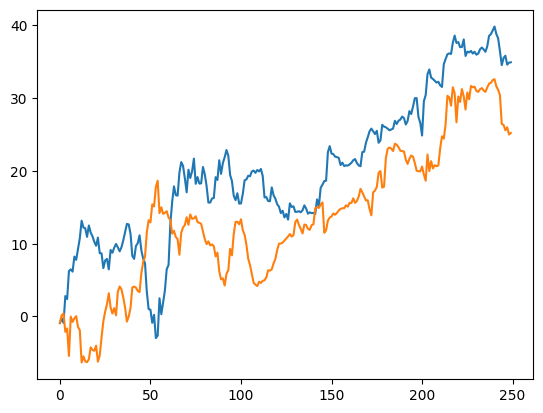

In [159]:
plt.plot(np.cumsum(pnl[:]))
plt.plot(np.cumsum(pnl_model_skew_long_short[:]))

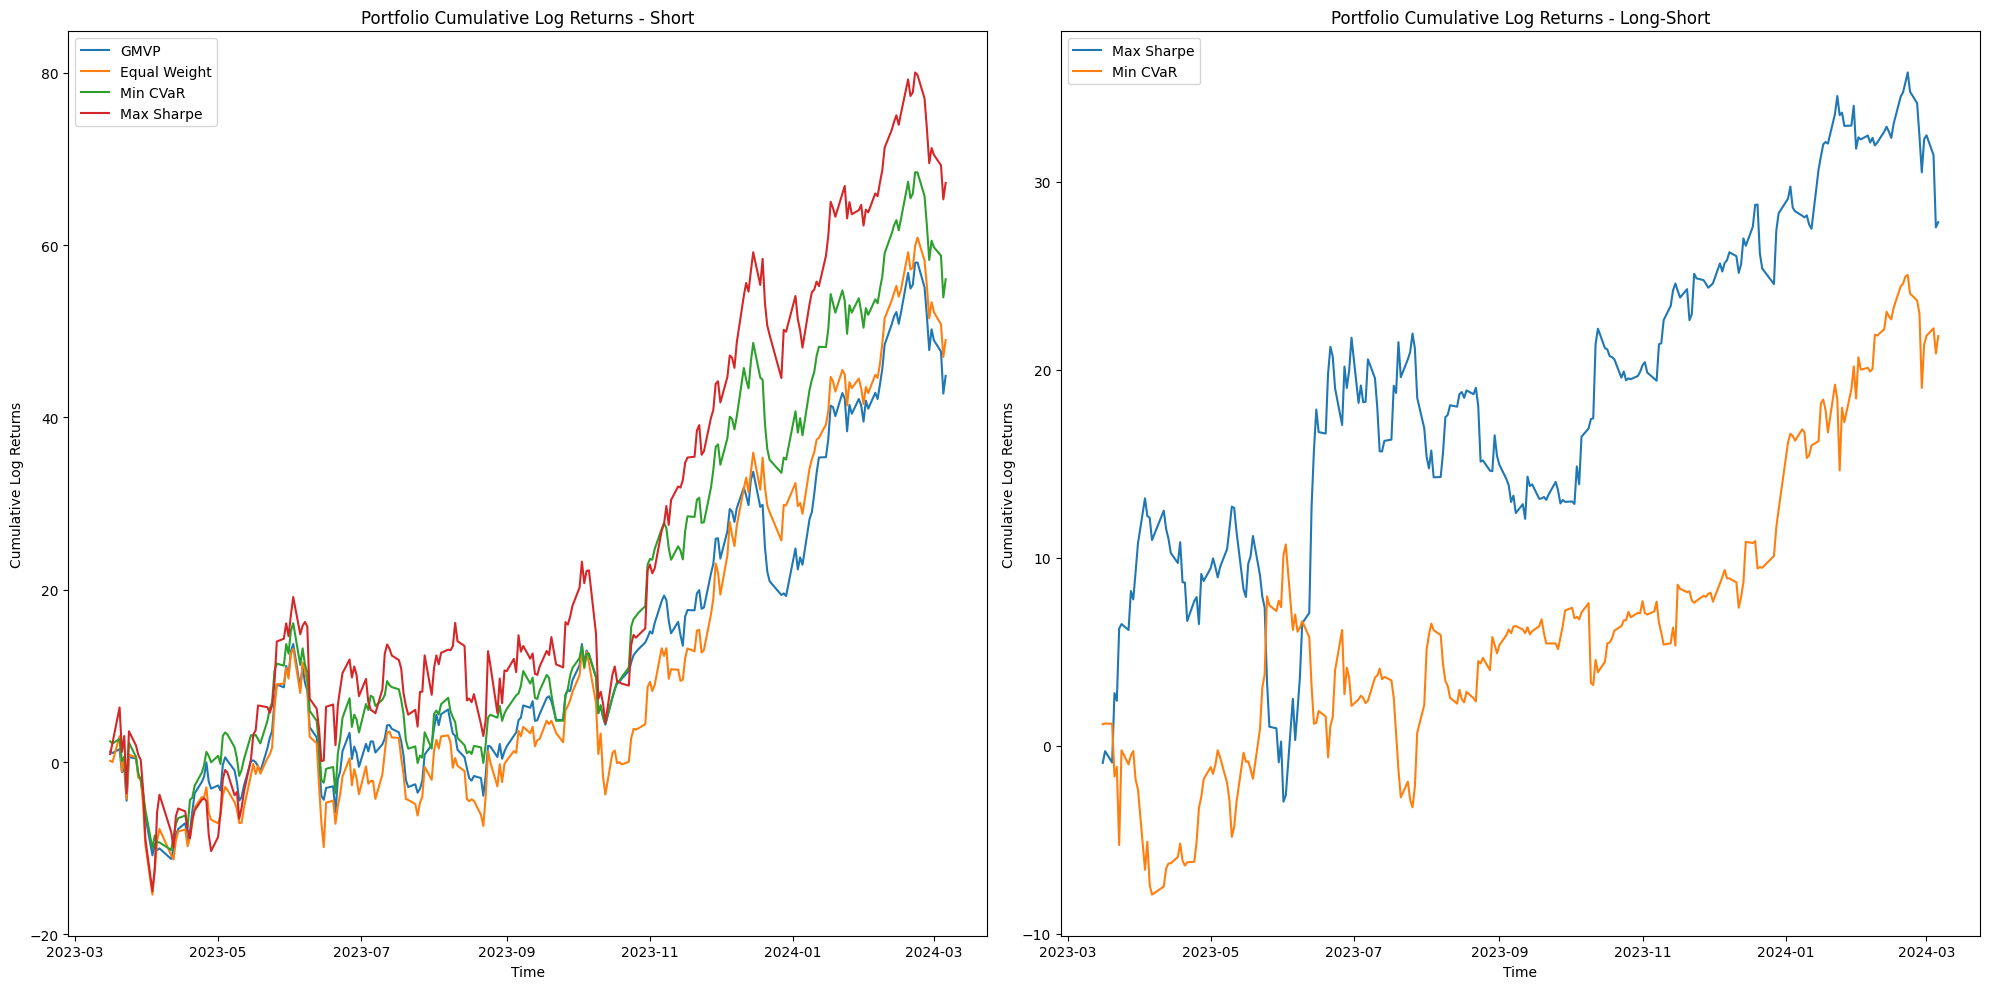

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 10))

# Plotting on the first subplot
ax1.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl_gmvp), label='GMVP')
ax1.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl_equal), label='Equal Weight')
ax1.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl_model_skew_short), label='Min CVaR')
ax1.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl_sharpe), label='Max Sharpe ')

ax1.set_title('Portfolio Cumulative Log Returns - Short')
ax1.set_xlabel('Time')
ax1.set_ylabel('Cumulative Log Returns')
ax1.legend()

# Plotting on the second subplot
ax2.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl), label='Max Sharpe')
ax2.plot(df_backtest.iloc[ - f_end :].index,np.cumsum(pnl_model_skew_2), label='Min CVaR')
ax2.set_title('Portfolio Cumulative Log Returns - Long-Short')
ax2.set_xlabel('Time')
ax2.set_ylabel('Cumulative Log Returns')
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()

In [ ]:
plt.plot(np.cumsum(pnl_gmvp[:]))
plt.plot(np.cumsum(pnl_equal[:]))
plt.plot(np.cumsum(pnl_model_skew_short[:]))
plt.plot(np.cumsum(pnl_sharpe[:]))

In [ ]:
plt.plot(np.cumsum(pnl[:]))
plt.plot(np.cumsum(pnl_model_skew_2[:]))

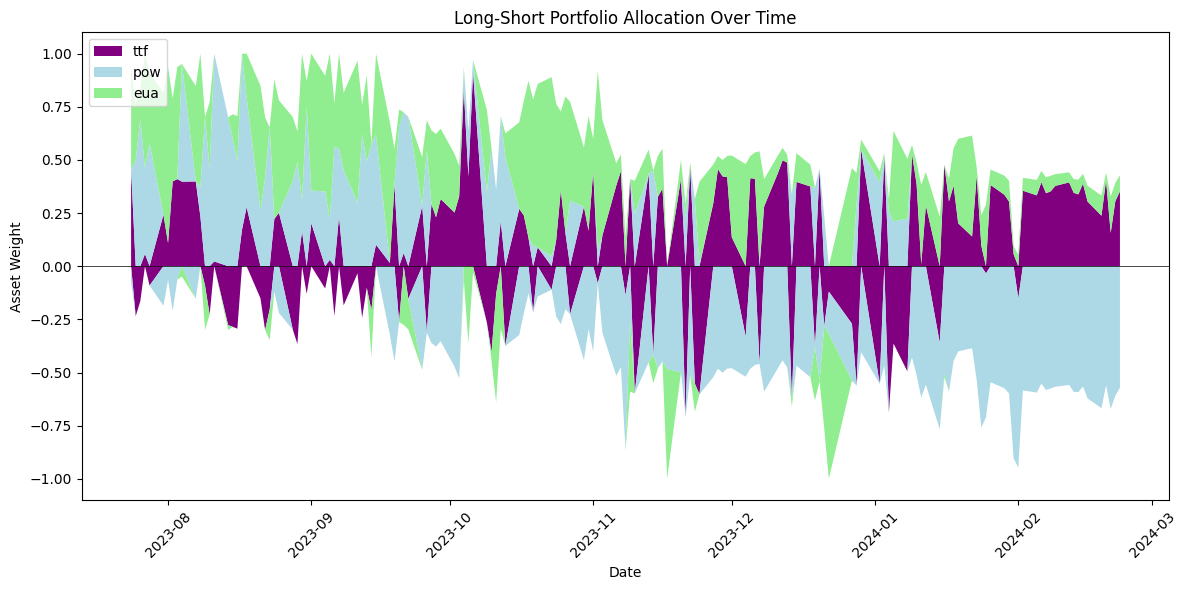

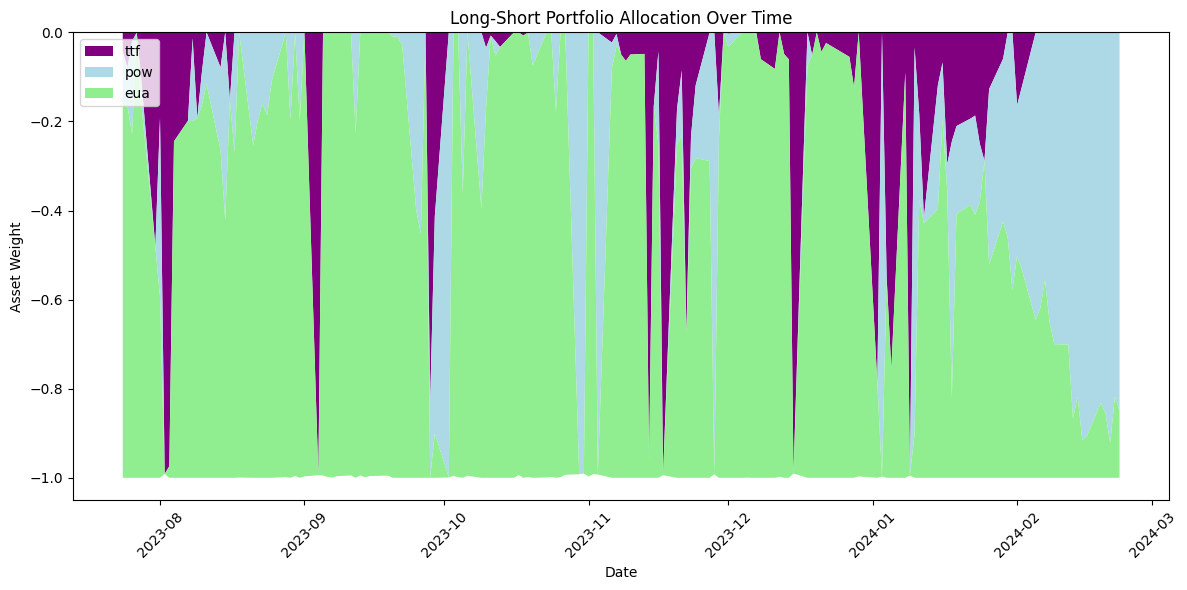

In [651]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_long_short_allocation(df):
    """
    Plot a stacked area chart for long-short portfolio allocation over time.

    Parameters:
    - df: A pandas DataFrame with datetime index and columns for each asset's weight.
          Positive values are long positions, and negative values are short positions.
    """
    
    # Convert the index to datetime if it's not already, this line can be commented
    # if the DataFrame already has a datetime index
    df.index = pd.to_datetime(df.index)

    # Separate the DataFrame into positive and negative parts
    pos_df = df.clip(lower=0)
    neg_df = df.clip(upper=0)

    # Create the plot
    plt.figure(figsize=(12, 6))
    
    # Plot positive weights
    plt.stackplot(df.index, pos_df.T, labels=pos_df.columns, baseline='zero', colors= ['purple','lightblue','lightgreen'] )
    
    # Plot negative weights
    plt.stackplot(df.index, neg_df.T,baseline='zero', colors= ['purple','lightblue','lightgreen'])
    
    # Add a horizontal line at y=0
    plt.axhline(0, color='black', linewidth=0.5)
    
    # Customize the legend
    plt.legend(loc='upper left')
    
    # Titles and labels
    plt.title('Long-Short Portfolio Allocation Over Time')
    plt.xlabel('Date')
    plt.ylabel('Asset Weight')

    # Rotate date labels
    plt.xticks(rotation=45)
    
    # Show plot
    plt.tight_layout()
    plt.show()

# Example usage:
# Assuming 'portfolio_data' is your DataFrame with the portfolio allocations
# plot_long_short_allocation(portfolio_data)

df_weights = pd.DataFrame(w_list)
df_weights['date'] = date
df_weights = df_weights.set_index('date')
df_weights.columns  = ['ttf','pow','eua']

df_weights_cvar = pd.DataFrame(w_list_cvar)
df_weights_cvar['date'] = date
df_weights_cvar = df_weights_cvar.set_index('date')
df_weights_cvar.columns  = ['ttf','pow','eua']

plot_long_short_allocation(df_weights)
plot_long_short_allocation(df_weights_cvar)

In [491]:
df_weights_cvar = pd.DataFrame(w_list_cvar)
df_weights_cvar['date'] = date
df_weights_cvar = df_weights_cvar.set_index('date')
df_weights_cvar.columns  = ['ttf','pow','eua']

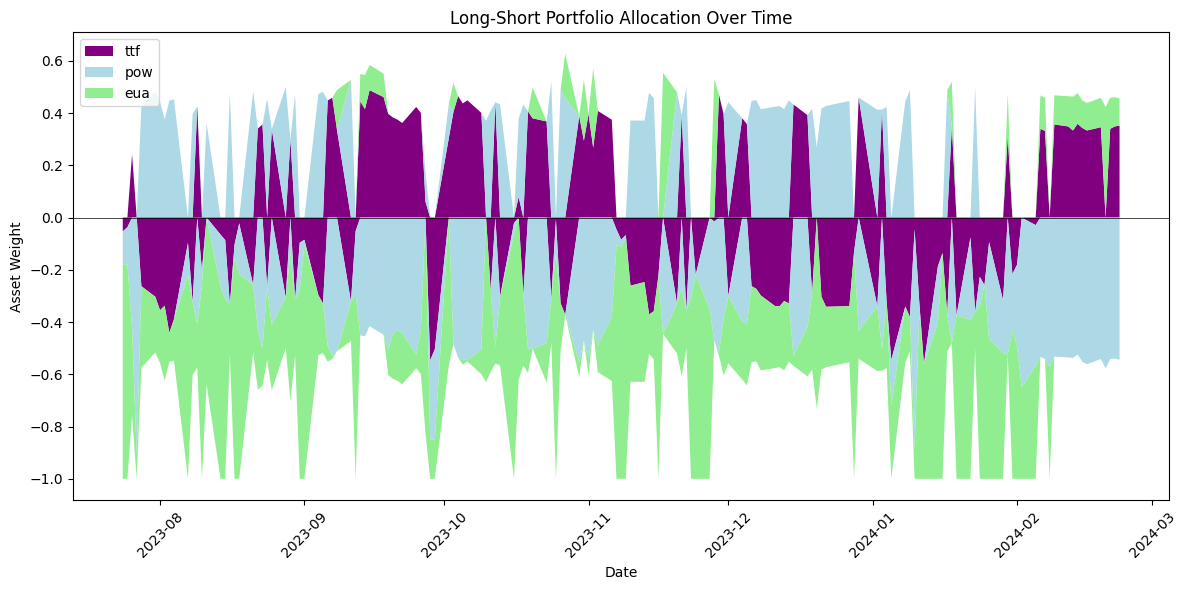

In [492]:
plot_long_short_allocation(df_weights_cvar)

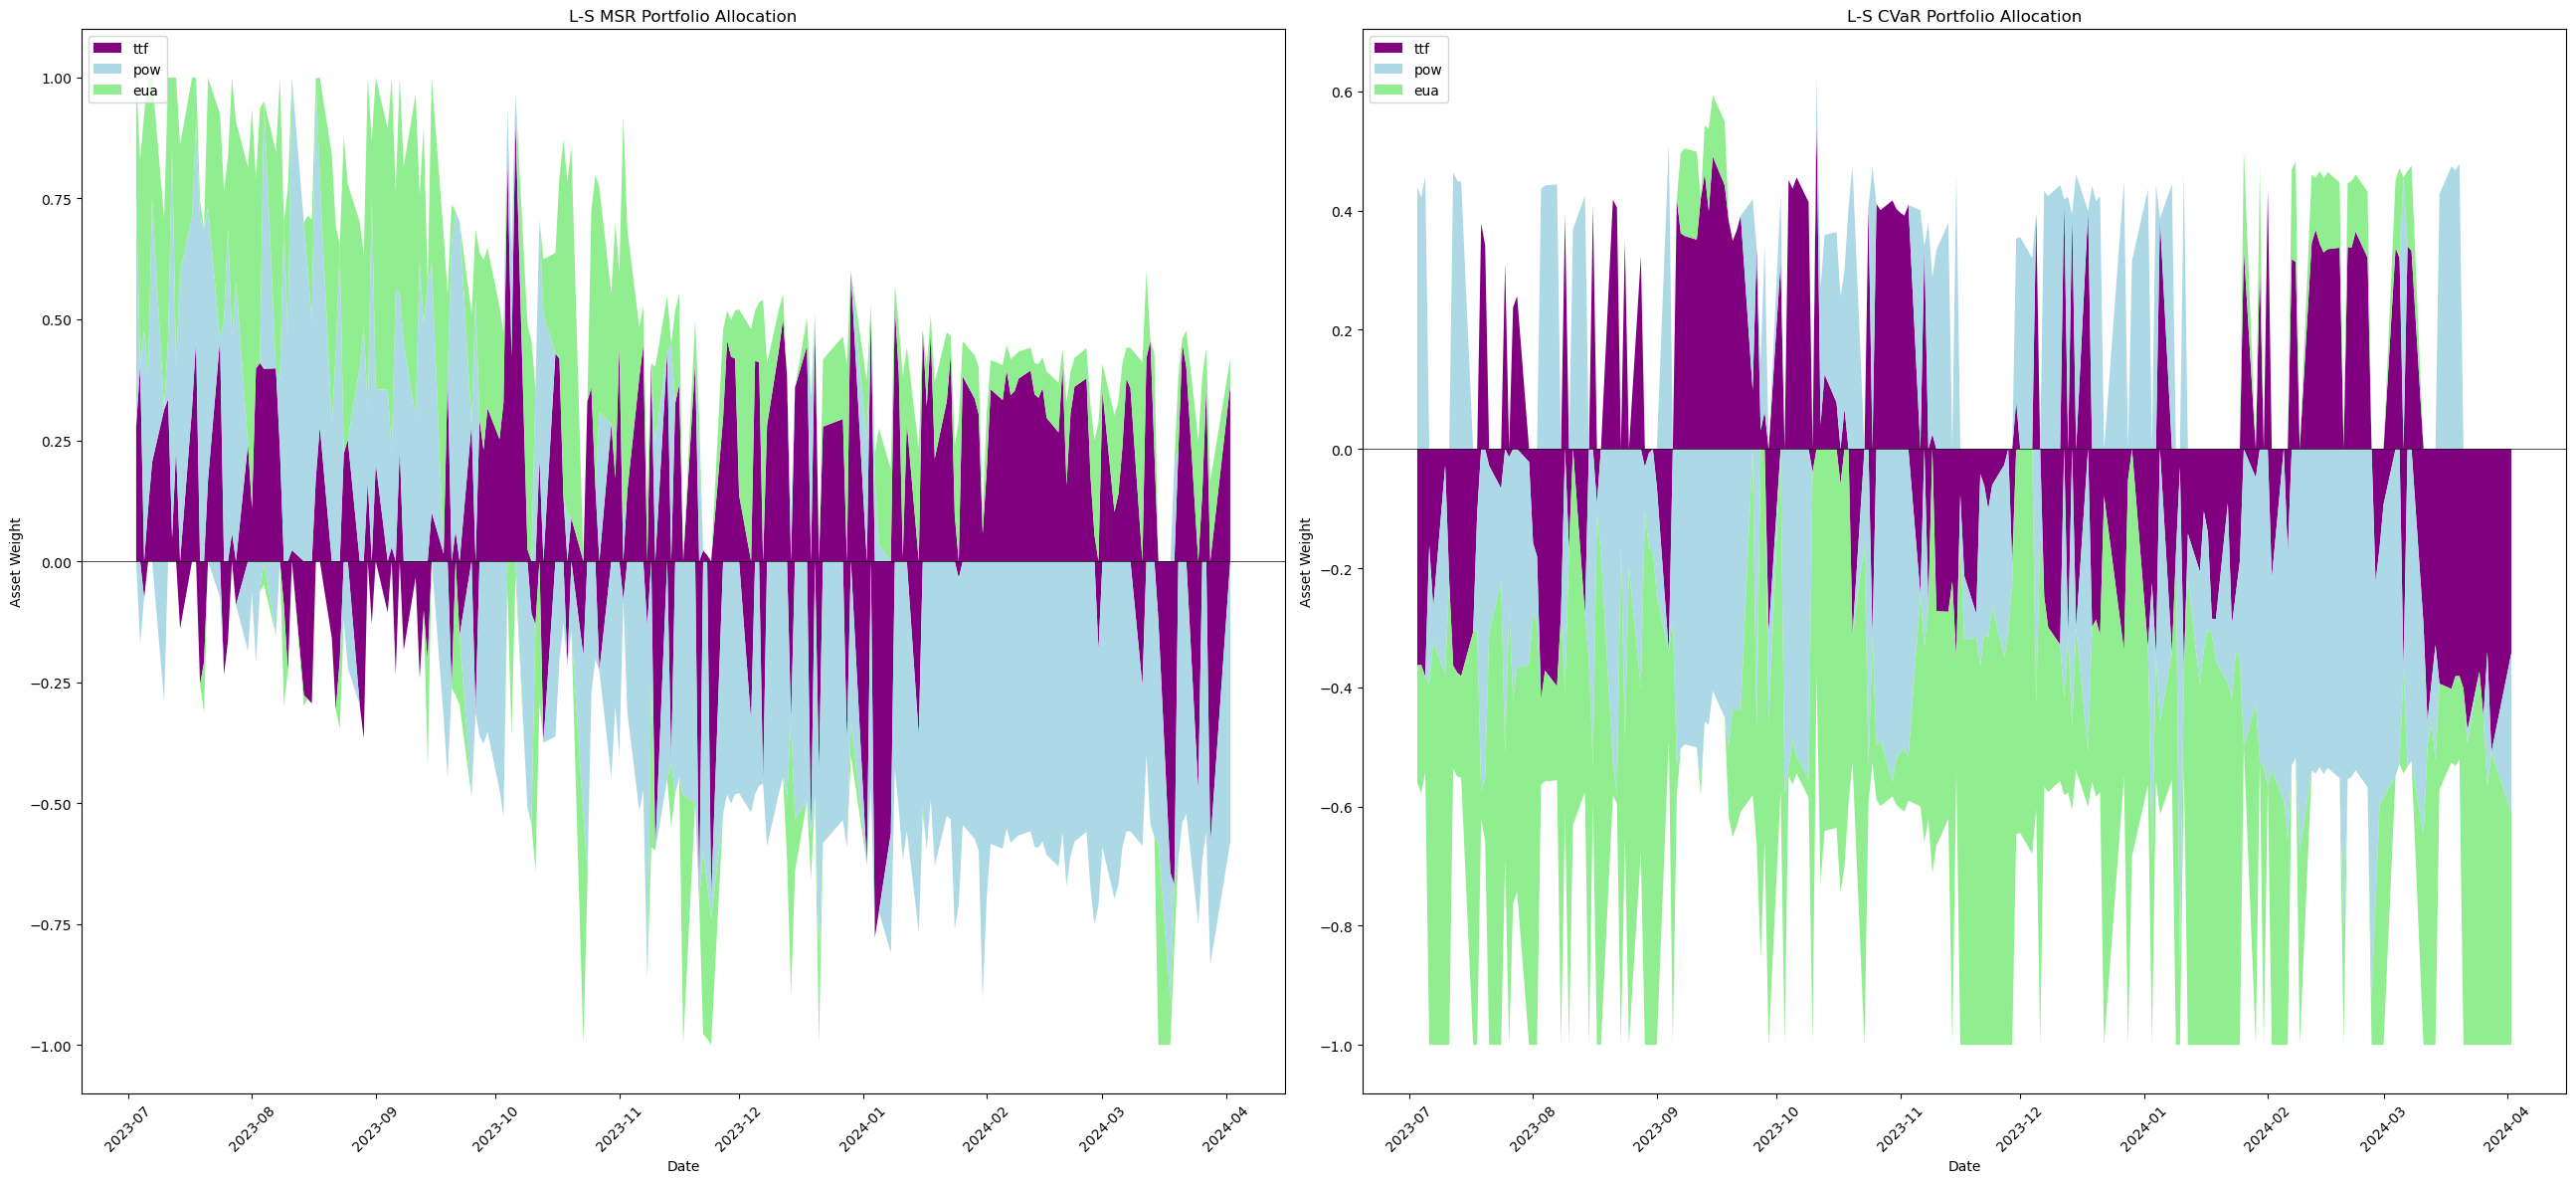

In [309]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_long_short_allocation_subplot(df, subplot_pos, fig, title):
    """
    Plot a stacked area chart for long-short portfolio allocation over time in a subplot.
    
    Parameters:
    - df: A pandas DataFrame with datetime index and columns for each asset's weight.
          Positive values are long positions, and negative values are short positions.
    - subplot_pos: Position of the subplot (e.g., 121 for 1 row, 2 columns, first position).
    - fig: The figure object on which to add the subplot.
    - title: Title for the subplot.
    """
    
    # Convert the index to datetime if it's not already
    df.index = pd.to_datetime(df.index)

    # Separate the DataFrame into positive and negative parts
    pos_df = df.clip(lower=0)
    neg_df = df.clip(upper=0)

    # Create the subplot
    ax = fig.add_subplot(subplot_pos)
    
    # Plot positive weights
    ax.stackplot(df.index, pos_df.T, labels=pos_df.columns, baseline='zero', colors= ['purple','lightblue','lightgreen'] )
    
    # Plot negative weights
    ax.stackplot(df.index, neg_df.T, baseline='zero', colors= ['purple','lightblue','lightgreen'])
    
    # Add a horizontal line at y=0
    ax.axhline(0, color='black', linewidth=0.5)
    
    # Customize the legend
    ax.legend(loc='upper left')
    
    # Titles and labels
    ax.set_title(title)
    ax.set_xlabel('Date')
    ax.set_ylabel('Asset Weight')

    # Rotate date labels
    plt.setp(ax.xaxis.get_majorticklabels(), rotation=45)
    
    # Tight layout for subplot
    plt.tight_layout()

# Example usage with your data:
fig = plt.figure(figsize=(26, 12))  # Adjust overall plot size if necessary

# Assuming 'df_weights' and 'df_weights_cvar' are your DataFrames
plot_long_short_allocation_subplot(df_weights, 121, fig, 'L-S MSR Portfolio Allocation')
plot_long_short_allocation_subplot(df_weights_cvar, 122, fig, 'L-S CVaR Portfolio Allocation')

plt.show()
